In [1]:
## Examine input and output to and from the RC.
def calculate_feeder_input_and_output(C, input_is_rowsum=True):
    if input_is_rowsum:
        input_axis = 0
        output_axis = 1
    else:
        input_axis = 1
        output_axis = 0

    # Create a 2D-mask for inter rich club connections.
    mask_inter_rc = np.zeros([n_rois, n_rois], dtype=bool)
    rc_ind_combin = np.array(list(
        itertools.product(indexes_rc, repeat=2))).T
    mask_inter_rc[rc_ind_combin[0], rc_ind_combin[1]] = True

    no_rc_connections_C = np.copy(C)
    no_rc_connections_C[mask_inter_rc] = 0
    if io_based_on_nodal_degree_flag:
        input_rc = np.squeeze(np.count_nonzero(no_rc_connections_C,
                                                axis=input_axis, keepdims=True))
        output_rc = np.squeeze(np.count_nonzero(no_rc_connections_C,
                                                 axis=output_axis, keepdims=True))
    else:
        input_rc = no_rc_connections_C[:, :].sum(axis=input_axis)
        output_rc = no_rc_connections_C[:, :].sum(axis=output_axis)

#    io_ratio_rc = input_rc[mask_rc] / output_rc[mask_rc]
#    # Calculate and print the mean io-ratio and the CI for rich club regions
#    io_ratio_rc_mean = io_ratio_rc[:].mean()
#    io_ratio_rc_conf_int = np.array(stt.t.interval(
#        0.95, io_ratio_rc.shape[0]-1, loc=io_ratio_rc_mean,
#        scale=stt.sem(io_ratio_rc)))
#    print('Mean input-to-output ratio of the rich club:\n',
#          str(io_ratio_rc_mean))
#    print('95% confidence interval (rich club):\n', str(io_ratio_rc_conf_int))
#    rc_ratio_of_total_io = (roi_input[mask_rc].sum()
#                            / roi_output[mask_rc].sum())
#    print('Total input to total output ratio between RC and periphery:\n',
#          str(rc_ratio_of_total_io))

    # Create a 2D-mask for inter periphery connections.
    mask_inter_periph = np.zeros([n_rois, n_rois], dtype=bool)
    periph_ind_combin = np.array(list(itertools.product(list(
        x for x in range(68) if x not in indexes_rc), repeat=2))).T
    mask_inter_periph[periph_ind_combin[0], periph_ind_combin[1]] = True
    # Calculate the ratio of incoming/outgoing EC among peripheral regions
    inter_periph_C = np.copy(C)
    inter_periph_C[~mask_inter_periph] = 0
    if io_based_on_nodal_degree_flag:
        input_periph = np.squeeze(np.count_nonzero(
            inter_periph_C, axis=input_axis, keepdims=True))
        output_periph = np.squeeze(np.count_nonzero(
            inter_periph_C, axis=output_axis, keepdims=True))
    else:
        input_periph = inter_periph_C[:, :].sum(axis=input_axis)
        output_periph = inter_periph_C[:, :].sum(axis=output_axis)

#    io_ratio_periph = (input_periph[~mask_rc] / output_periph[~mask_rc])
#    # Calculate and print the mean io-ratio and the CI for peripheral regions
#    io_ratio_periph_mean = io_ratio_periph.mean()
#    io_ratio_periph_conf_int = np.array(stt.t.interval(
#        0.95, io_ratio_periph.shape[0]-1, loc=io_ratio_periph_mean,
#        scale=stt.sem(io_ratio_periph)))
#    print('Mean input-to-output ratio of the priphery:\n',
#          str(io_ratio_periph_mean))
#    print('95% confidence interval (periphery):\n',
#          str(io_ratio_periph_conf_int))
#    periph_ratio_of_total_io = (roi_input[~mask_rc].sum()
#                                / roi_output[~mask_rc].sum())
#    print('Total input to total output ratio of the priphery:\n',
#          str(periph_ratio_of_total_io))
    return input_rc, output_rc, input_periph, output_periph

In [39]:
def examine_significance(dist_patients, dist_controls, 
                         statistic_patients, statistic_controls,
                         statistic_description, y_labels, alpha, stat_fun):
    n_samples, n_subjects = group_samples.shape
    if sample_groupsize== 'matched':
        dist_patients = dist_patients[:n_subjects, :]
        dist_controls = dist_controls[:n_subjects, :]
        distribution = np.concatenate((dist_patients, dist_controls),
                                     axis=0)
    else:
        distribution = np.concatenate(
            (dist_patients, dist_controls), axis=0)    
    groups = np.array([distribution[group_sample.astype(int), :]
                                          for group_sample in group_samples])
    alpha = alpha # alpha percentile
    lower_limit = int(np.floor(n_samples * (1 - alpha) / 2))
    upper_limit = int(np.floor(n_samples * (1 + alpha) / 2))
    rankordered_samples = np.sort(stat_fun(groups, axis=1), axis=0)
    rankordered_samples = rankordered_samples[lower_limit:upper_limit, :]
    xerr = rankordered_samples[[0,-1], :]

    fontsize = 15
    markersize = 18
    y = np.arange(xerr.shape[1])
    fig = plt.figure(figsize=(25, len(y_labels)/3))
    plt.rcParams['axes.ymargin'] = 0.01
    plt.subplot(121)
    plt.hlines(np.matlib.repmat(y, 2, 1), xmin=xerr[0], xmax=xerr[1], color='b')
    plt.plot(xerr, np.matlib.repmat(y, 2, 1), '|', color='b', markersize=10)
    plt.plot(rankordered_samples.mean(axis=0), y, '|', color='b', markersize=5)
    for i_rc_roi in range(xerr.shape[1]):
        i_statistic_patients = statistic_patients[i_rc_roi]
        format_string = '.r'
        if (i_statistic_patients > xerr.T[i_rc_roi,1] or
            i_statistic_patients < xerr.T[i_rc_roi,0]):
            format_string = '.g' 
        plt.plot(i_statistic_patients, y_labels[i_rc_roi],
                 format_string, markersize=markersize)
    plt.title(statistic_description + ' for patients',
              fontsize=title_fontsize)
    #plt.show()

    #fig = plt.figure()
    plt.subplot(122)
    plt.hlines(np.matlib.repmat(y, 2, 1), xmin=xerr[0], xmax=xerr[1], color='b')
    plt.plot(xerr, np.matlib.repmat(y, 2, 1), '|', color='b', markersize=10)
    plt.plot(rankordered_samples.mean(axis=0), y, '|', color='b', markersize=5)
    for i_rc_roi in range(xerr.shape[1]):
        i_statistic_controls = statistic_controls[i_rc_roi]
        format_string = '.r'
        if (i_statistic_controls > xerr.T[i_rc_roi,1] or
            i_statistic_controls < xerr.T[i_rc_roi,0]):
            format_string = '.g' 
        plt.plot(i_statistic_controls, y_labels[i_rc_roi],
                 format_string, markersize=markersize)
    plt.title(statistic_description + ' for controls',
              fontsize=title_fontsize)
    plt.tight_layout(h_pad=1)
    plt.show()

In [3]:
def plot_feeder_io_group_comparing_boxplot(input_patients, output_patients,
                              input_controls, output_controls, cmap):
    max_input = np.append(input_patients, input_controls).max()+1
    min_input = np.append(input_patients, input_controls).min()-1
    max_output = np.append(output_patients, output_controls).max()+1
    min_output = np.append(output_patients, output_controls).min()-1
    
    NUM_COLORS = max([len(input_Counter_subjects_total_patients),
                      len(input_Counter_subjects_total_controls),
                      len(input_Counter_subjects_total_controls),
                      len(output_Counter_subjects_total_patients)])
    cm = plt.get_cmap(cmap)
    
    plt.figure(figsize=(14, 10))
    plt.suptitle('Input', fontsize=suptitle_fontsize)
    plt.subplots_adjust(top=top_adjust)
    ax = plt.subplot(121)
    NUM_COLORS = len(input_Counter_subjects_total_patients)
    ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    plt.title('Patient', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('input', fontsize=axis_lable_fontsize)
    plt.xlim(min_input, max_input)
    n_rois = input_patients.shape[1]
    plt.boxplot(input_patients, positions = np.arange(n_rois), vert=False)
    
    #[plt.scatter(input_patients[max_ind], np.arange(n_rois), s=50, marker='o')
    # for max_ind in sorted(input_Counter_subjects_total_patients)]
    [plt.plot(input_patients[max_ind], np.arange(n_rois), markersize=10, 
              marker='o', linestyle='None', label=str(max_ind))
              for max_ind in sorted(input_Counter_subjects_total_patients)]
    plt.legend(title='subject index')
    ax = plt.subplot(122)
    NUM_COLORS = len(input_Counter_subjects_total_controls)
    ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    plt.title('Control', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('input', fontsize=axis_lable_fontsize)
    plt.xlim(min_input, max_input)
    n_rois = input_controls.shape[1]
    plt.boxplot(input_controls, positions = np.arange(n_rois), vert=False)
    
    #[plt.scatter(input_controls[max_ind], np.arange(n_rois), s=50, marker='o')
    # for max_ind in sorted(input_Counter_subjects_total_controls)]
    [plt.plot(input_controls[max_ind], np.arange(n_rois), markersize=10, 
              marker='o', linestyle='None', label=str(max_ind))
              for max_ind in sorted(input_Counter_subjects_total_controls)]
    plt.legend(title='subject index')
    plt.show()
    plt.figure(figsize=(14, 10))
    plt.suptitle('Output', fontsize=suptitle_fontsize)
    plt.subplots_adjust(top=top_adjust)
    ax = plt.subplot(121)
    NUM_COLORS = len(output_Counter_subjects_total_patients)
    ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    plt.title('Patient', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('output', fontsize=axis_lable_fontsize)
    plt.xlim(min_output, max_output)
    n_rois = output_patients.shape[1]
    plt.boxplot(output_patients, positions = np.arange(n_rois), vert=False)
    
    #[plt.scatter(output_patients[max_ind], np.arange(n_rois), s=50, marker='o')
    # for max_ind in sorted(output_Counter_subjects_total_patients)]
    [plt.plot(output_patients[max_ind], np.arange(n_rois), markersize=10, 
              marker='o', linestyle='None', label=str(max_ind))
              for max_ind in sorted(output_Counter_subjects_total_patients)]
    plt.legend(title='subject index')
    ax = plt.subplot(122)
    NUM_COLORS = len(output_Counter_subjects_total_controls)
    ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    plt.title('Control', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('output', fontsize=axis_lable_fontsize)
    plt.xlim(min_output, max_output)
    n_rois = output_controls.shape[1]
    plt.boxplot(output_controls, positions = np.arange(n_rois), vert=False)
    
    #[plt.scatter(output_controls[max_ind], np.arange(n_rois), s=50, marker='o')
    # for max_ind in sorted(output_Counter_subjects_total_controls)]
    [plt.plot(output_controls[max_ind], np.arange(n_rois), markersize=10, 
              marker='o', linestyle='None', label=str(max_ind))
              for max_ind in sorted(output_Counter_subjects_total_controls)]
    plt.legend(title='subject index')
    plt.show()

In [4]:
## Examine io ratio of RC regions.
def plot_rc_io_ratio(io_ratio_rc_patients, io_ratio_rc_controls,
                     indexes_rc):
    plt.figure(figsize=(32, 10))
    plt.subplot(121)
    plt.title('Patients', fontsize=suptitle_fontsize)
    plt.subplots_adjust(top=top_adjust)
    n_rois = io_ratio_rc_patients.shape[1]
    plt.boxplot(io_ratio_rc_patients, positions = np.arange(n_rois),
                vert=False)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.yticks(np.arange(n_rois), roi_labels[indexes_rc],
           fontsize=fontsize)
    plt.xlabel('io ratio', fontsize=axis_lable_fontsize)
    plt.subplot(122)
    plt.title('Controls', fontsize=suptitle_fontsize)
    n_rois = io_ratio_rc_controls.shape[1]
    plt.boxplot(io_ratio_rc_controls, positions = np.arange(n_rois),
                vert=False)
    plt.yticks(np.arange(n_rois), roi_labels[indexes_rc],
           fontsize=fontsize)
    plt.xlabel('io ratio', fontsize=axis_lable_fontsize)
    plt.show()

In [5]:
## Import dependencies.
import itertools
from scipy.io import loadmat, savemat, matlab
import scipy.stats as stt
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn as sns
#from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter

## Check whether simple_colors is installed, otherwise install using pip
try:
    from simple_colors import * # for printing colored and bold text
except:
    ! pip install simple_colors

## Import simple_colors
from simple_colors import *

## Flags.
sample_groupsize= 'matched' # Valid options: 'matched', 'all subjects'
# Flag 1
quick_optimize_flag = False
if quick_optimize_flag:
    epsilon_C = 0.001
else:
    epsilon_C = 0.0001
FC_scale = 'standard_scale' # Options: 'max_scale', 'standard_scale'
# Flag 2
io_based_on_nodal_degree_flag = False
# Flag 3
allow_all_connections_for_EC_flag = False
# Flag 4
optimize_with_FC_version = 'ts_scaled' # Options: 'FC_scaled','FC', 'ts_scaled'
# Flag 5
input_is_rowsum_flag = True # If == False, input = columnsum
# Flag 6
scale_ts_flag = True

## Introduce constants.
_FIGURES_DIR = 'subjectwise_feeder_analysis_figures'
_RES_DIR = str(
    'flag1-' + str(int(quick_optimize_flag)) +
    ' flag2-' + str(int(io_based_on_nodal_degree_flag)) +
    ' flag3-' + str(int(allow_all_connections_for_EC_flag)) +
    ' flag4-' + str(optimize_with_FC_version) +
    ' flag5-' + str(int(input_is_rowsum_flag)) +
    ' flag6-' + str(int(scale_ts_flag)) + '/')
_I_REST_RUN = 0
_I_NBACK_RUN = 1
_I_NO_TIMESHIFT = 0
_I_ONE_TIMESHIFT = 1
_SUBJECT_AXIS = 0
seed = 0 # None

In [6]:
# Load EC per subject for patients & control group.
C_patients_dict = np.load(_RES_DIR + 'C_patients_dict.npy', allow_pickle=True).tolist()
C_controls_dict = np.load(_RES_DIR + 'C_controls_dict.npy', allow_pickle=True).tolist()
# Load parametes.
parameter_dict = np.load(_RES_DIR + 'parameter_dict.npy', allow_pickle=True).tolist()
roi_labels = parameter_dict['roi_labels']
mask_EC = parameter_dict['mask_EC']
group_samples = np.load(_RES_DIR + 'group_samples.npy')
J_patients = np.load(_RES_DIR + 'J_patients.npy')
J_controls = np.load(_RES_DIR + 'J_controls.npy')
Sigma_patients = np.load(_RES_DIR + 'Sigma_patients.npy')
Sigma_controls = np.load(_RES_DIR + 'Sigma_controls.npy')
dist_patients = np.load(_RES_DIR + 'dist_patients.npy')
dist_controls = np.load(_RES_DIR + 'dist_controls.npy')
R2_patients = np.load(_RES_DIR + 'R2_patients.npy')
R2_controls = np.load(_RES_DIR + 'R2_controls.npy')
C_patients = C_patients_dict['C_mod']
C_controls = C_controls_dict['C_mod']
print('epsilon_C =', C_patients_dict['epsilon_C'])

epsilon_C = 1e-05


In [7]:
## Calculate the feeder input and output.
# Define constants.
n_patients, n_rois, _ = C_patients.shape
n_controls, _, _ = C_controls.shape
# Define RC.
rc_labels = ['precuneus', 'superiorfrontal', 'superiorparietal']
mask_rc = np.zeros(n_rois, dtype=bool)
for i_rc_label in rc_labels:
    mask_rc[np.frompyfunc(lambda x: i_rc_label in x, 1, 1)(roi_labels).astype(
        bool)] = True
indexes_rc = np.array(*np.where(mask_rc))
print(black('Rich club regions:\n', 'bold'), roi_labels[mask_rc].tolist())

#[roi_input, roi_output, io_ratio_rc,
# io_ratio_periph] = calculate_feeder_input_and_output(C)
#[roi_input_controls, roi_output_controls, io_ratio_rc_controls,
# io_ratio_periph_controls] = calculate_feeder_input_and_output(C_controls)

#print(black('\nPatient group:', 'bold'))
[input_patients, output_patients, input_periph_patients,
output_periph_patients] = np.squeeze(np.split(
    np.array([ calculate_feeder_input_and_output(x) for x in C_patients ]),
    4, axis=1))
#print(black('\nControl group:', 'bold'))
[input_controls, output_controls, input_periph_controls,
output_periph_controls] = np.squeeze(np.split(
    np.array([ calculate_feeder_input_and_output(x) for x in C_controls ]),
    4, axis=1))

Rich club regions:
 ['lh_precuneus', 'lh_superiorfrontal', 'lh_superiorparietal', 'rh_precuneus', 'rh_superiorfrontal', 'rh_superiorparietal']


(68,)


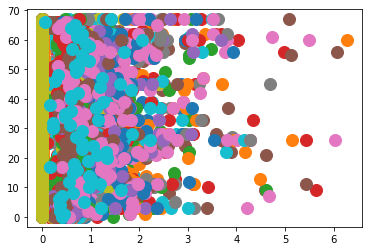

In [8]:
plt.figure()
[plt.plot(input_patient, np.arange(n_rois), markersize=12, marker='o', 
          linestyle='None') for input_patient in input_patients]
plt.show()

RC-indexes:
 [23 26 27 57 60 61]
Investigate input and output regionwise for RC-periphery (feeder) connections:


No handles with labels found to put in legend.
No handles with labels found to put in legend.


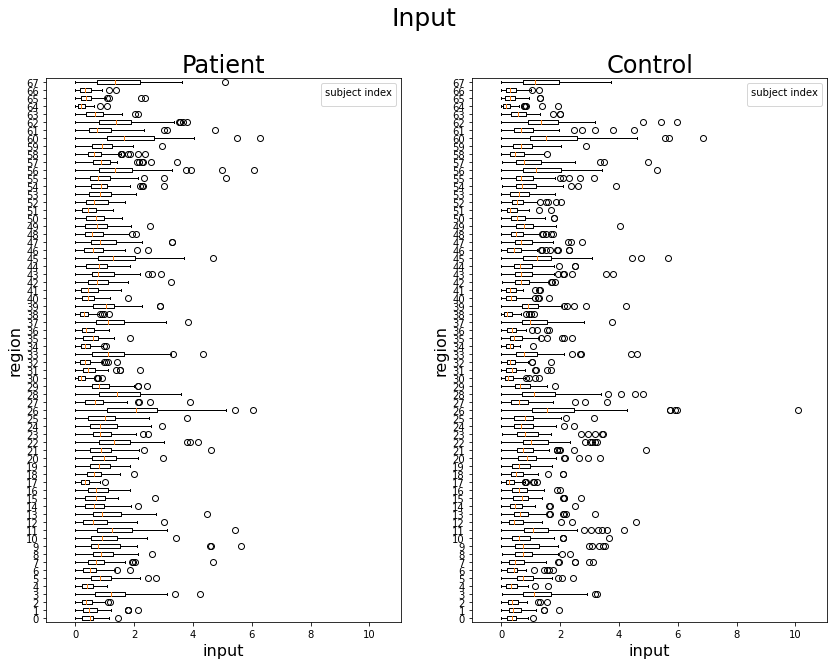

No handles with labels found to put in legend.
No handles with labels found to put in legend.


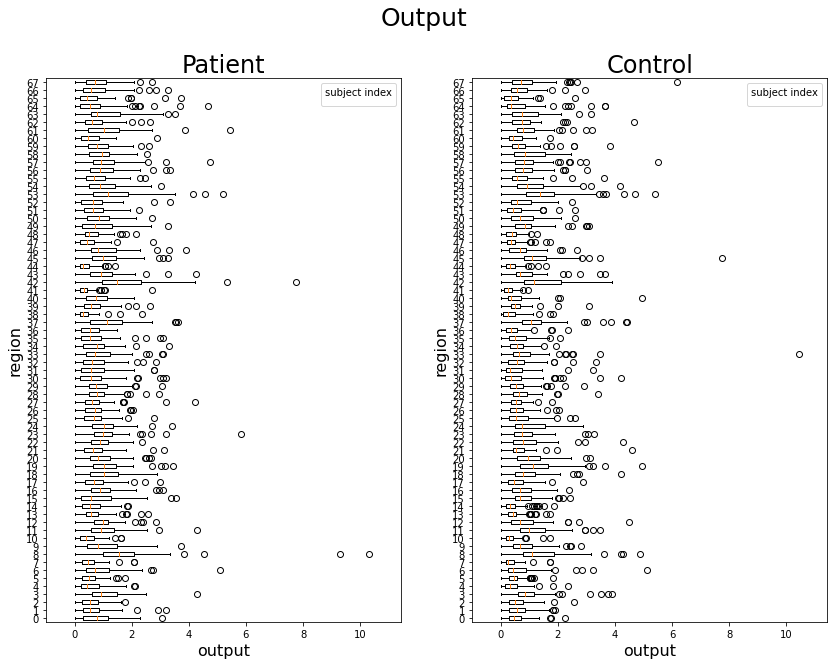

Mean rc input:	 0.8316169937519278 (patients)	 0.754484797162674 (contols)


In [9]:

suptitle_fontsize = 25
title_fontsize = 24
axis_lable_fontsize = 16
fontsize = 15
top_adjust = 0.88
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(red('Investigate input and output regionwise for RC-periphery'
          ' (feeder) connections:', 'bold'))
#plot_feeder_io_boxplot(input_patients, output_patients, 'Patients')
#plot_feeder_io_boxplot(input_controls, output_controls, 'Controls')
input_Counter_subjects_total_patients = []
input_Counter_subjects_total_controls = []
output_Counter_subjects_total_patients = []
output_Counter_subjects_total_controls = []
plot_feeder_io_group_comparing_boxplot(
    input_patients, output_patients, input_controls, output_controls, 'jet')
print('Mean rc input:\t', input_patients.mean(),
  '(patients)\t', input_controls.mean(), '(contols)')

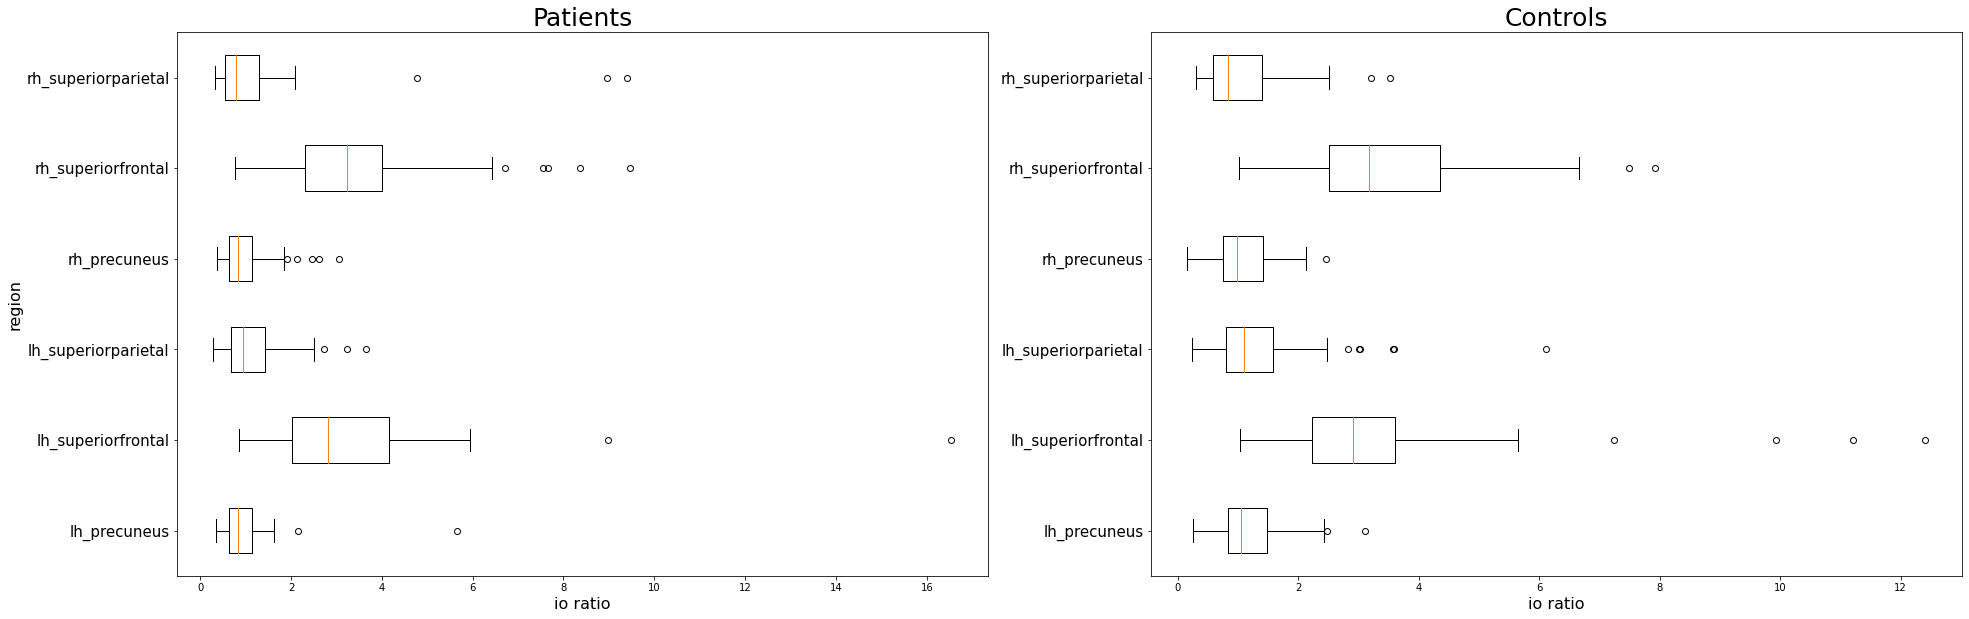

Mean rc io ratio:	 1.8643245357693237 (patients)	 1.9210173988945383 (contols)


In [10]:
io_ratio_rc_patients = (input_patients[:, mask_rc]
                        / output_patients[:, mask_rc])
io_ratio_rc_controls = (input_controls[:, mask_rc]
                        / output_controls[:, mask_rc])
plot_rc_io_ratio(io_ratio_rc_patients, io_ratio_rc_controls, indexes_rc)

io_ratio_rc_mean_patients = io_ratio_rc_patients.mean()
io_ratio_rc_mean_controls = io_ratio_rc_controls.mean()
print('Mean rc io ratio:\t', io_ratio_rc_mean_patients,
      '(patients)\t', io_ratio_rc_mean_controls, '(contols)')

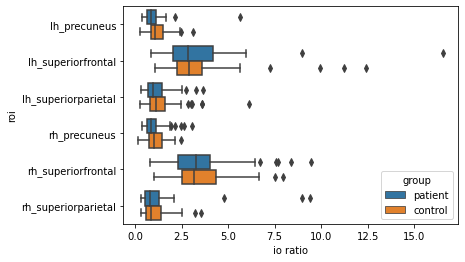

The patient`s variance is greater than the control`s for 5 of 6 rc regions.


In [11]:
## Compare groups in one boxplot with respect to io ratio of rc regions. 
dataframe_patients = pd.DataFrame(io_ratio_rc_patients.reshape(-1),
                                  columns=['io ratio'])
dataframe_patients['group'] = np.repeat('patient', dataframe_patients.size)
dataframe_patients['roi'] = np.matlib.repmat(
    roi_labels[mask_rc], n_patients, 1).reshape(-1)

dataframe_controls = pd.DataFrame(io_ratio_rc_controls.reshape(-1),
                                  columns=['io ratio'])
dataframe_controls['group'] = np.repeat('control', dataframe_controls.size)
dataframe_controls['roi'] = np.matlib.repmat(
    roi_labels[mask_rc], n_controls, 1).reshape(-1)

dataframe_all_subjects = dataframe_patients.append(dataframe_controls)

ax = sns.boxplot(x = dataframe_all_subjects['io ratio'], 
            y = dataframe_all_subjects['roi'], 
            hue = dataframe_all_subjects['group'])
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":16})
#ax.set_title("Title",fontsize=24)
plt.show()
roi_count_patients_greater_than_controls = sum(
    np.var(io_ratio_rc_patients, axis=0) > np.var(io_ratio_rc_controls, axis=0))
print('The patient`s variance is greater than the control`s for', 
      roi_count_patients_greater_than_controls, 'of', 
      len(indexes_rc), 'rc regions.')

In [12]:
"""
Patients: Analyse input from the periphery into the rc with regard
to max values. 
"""

n_max_values = 5
# Find subjects responsible for the outliers.
print(black('Input: Examine the subjects responsible for the largest value per region:', 'bold'))
input_Counter_subjects_total_patients = Counter()
input_Counter_rois_total_patients = Counter()
output_Counter_subjects_total_patients = Counter()
output_Counter_rois_total_patients = Counter()
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = input_patients.T == np.outer(np.sort(
        input_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
    print(np.asarray(condition).nonzero())
    input_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    print(input_Counter_subjects)
    print(sorted(input_Counter_subjects))
    input_Counter_subjects_total_patients += input_Counter_subjects
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))
# Find rois responsible for the largest values per subject
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(black('Input: Examine the rois responsible for the largest value per subject:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = input_patients == np.outer(np.sort(
        input_patients, axis=1)[:, -i_max-1], np.ones([n_rois]))
    print(np.asarray(condition).nonzero())
    input_Counter_rois = Counter(np.asarray(condition).nonzero()[1])
    print(input_Counter_rois)
    print(sorted(input_Counter_rois))
    input_Counter_rois_total_patients += input_Counter_rois
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))

## Analyse rc output with regard to max values.
# Find subjects responsible for the outliers.
print(black('Output: Examine the subjects responsible for the largest value per region:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = output_patients.T == np.outer(np.sort(
        output_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
    print(np.asarray(condition).nonzero())
    output_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    print(output_Counter_subjects)
    print(sorted(output_Counter_subjects))
    output_Counter_subjects_total_patients += output_Counter_subjects
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))
# Find rois responsible for the largest values per subject
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(black('Output: Examine the rois responsible for the largest value per subject:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = output_patients == np.outer(np.sort(
        output_patients, axis=1)[:, -i_max-1], np.ones([n_rois]))
    print(np.asarray(condition).nonzero())
    output_Counter_rois = Counter(np.asarray(condition).nonzero()[1])
    print(output_Counter_rois)
    print(sorted(output_Counter_rois))
    output_Counter_rois_total_patients += output_Counter_rois
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))

## Analyse rc io ratio with regard to max values. 
print(black('Examine the subjects responsible for the largest io ratio:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = io_ratio_rc_patients.T == np.outer(np.sort(
        io_ratio_rc_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
    print(np.asarray(condition).nonzero())
    print(Counter(np.asarray(condition).nonzero()[1]))
    print(sorted(Counter(np.asarray(condition).nonzero()[1])))
    

Input: Examine the subjects responsible for the largest value per region:
	 1. largest value
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
      dtype=int64), array([12, 21,  0, 46,  7, 37, 12, 46,  5,  3, 23,  5, 50, 21, 21, 12, 11,
       12, 21, 12, 21,  5, 21, 31,  5,  5, 46,  7,  5, 12, 50, 21, 12,  3,
       23, 12,  3,  5, 37,  3, 12, 46, 46, 21, 37,  7, 29, 46, 21, 12, 12,
       46, 21,  5, 12,  5,  5, 12, 35,  5, 21, 46,  7, 21,  0, 46, 12,  5],
      dtype=int64))
Counter({12: 14, 21: 12, 5: 12, 46: 9, 7: 4, 3: 4, 37: 3, 0: 2, 23: 2, 50: 2, 11: 1, 31: 1, 29: 1, 35: 1})
[0, 3, 5, 7, 11, 12, 21, 23, 29, 31, 35, 37, 46, 50]
	 2. largest value
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17

In [13]:
"""
Patients: Analyse input from the periphery into the rc with regard
to max values. 
"""

n_max_values = 5
# Find subjects responsible for the outliers.
print(black('Input: Examine the subjects responsible for the largest value per region:', 'bold'))
input_Counter_subjects_total_controls = Counter()
input_Counter_rois_total_controls = Counter()
output_Counter_subjects_total_controls = Counter()
output_Counter_rois_total_controls = Counter()
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = input_controls.T == np.outer(np.sort(
        input_controls, axis=0)[-i_max-1, :], np.ones([n_controls]))
    print(np.asarray(condition).nonzero())
    input_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    print(input_Counter_subjects)
    print(sorted(input_Counter_subjects))
    input_Counter_subjects_total_controls += input_Counter_subjects
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))
# Find rois responsible for the largest values per subject
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(black('Input: Examine the rois responsible for the largest value per subject:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = input_controls == np.outer(np.sort(
        input_controls, axis=1)[:, -i_max-1], np.ones([n_rois]))
    print(np.asarray(condition).nonzero())
    input_Counter_rois = Counter(np.asarray(condition).nonzero()[1])
    print(input_Counter_rois)
    print(sorted(input_Counter_rois))
    input_Counter_rois_total_controls += input_Counter_rois
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))

## Analyse rc output with regard to max values.
# Find subjects responsible for the outliers.
print(black('Output: Examine the subjects responsible for the largest value per region:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = output_controls.T == np.outer(np.sort(
        output_controls, axis=0)[-i_max-1, :], np.ones([n_controls]))
    print(np.asarray(condition).nonzero())
    output_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    print(output_Counter_subjects)
    print(sorted(output_Counter_subjects))
    output_Counter_subjects_total_controls += output_Counter_subjects
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))
# Find rois responsible for the largest values per subject
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(black('Output: Examine the rois responsible for the largest value per subject:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = output_controls == np.outer(np.sort(
        output_controls, axis=1)[:, -i_max-1], np.ones([n_rois]))
    print(np.asarray(condition).nonzero())
    output_Counter_rois = Counter(np.asarray(condition).nonzero()[1])
    print(output_Counter_rois)
    print(sorted(output_Counter_rois))
    output_Counter_rois_total_controls += output_Counter_rois
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))

## Analyse rc io ratio with regard to max values. 
print(black('Examine the subjects responsible for the largest io ratio:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = io_ratio_rc_controls.T == np.outer(np.sort(
        io_ratio_rc_controls, axis=0)[-i_max-1, :], np.ones([n_controls]))
    print(np.asarray(condition).nonzero())
    print(Counter(np.asarray(condition).nonzero()[1]))
    print(sorted(Counter(np.asarray(condition).nonzero()[1])))

Input: Examine the subjects responsible for the largest value per region:
	 1. largest value
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
      dtype=int64), array([57, 57,  8, 46, 46, 57,  8, 46,  8, 46, 46, 57,  5, 46, 38,  8,  8,
       21, 57,  8, 57, 33,  8,  5,  8,  8, 38,  7, 57, 46, 57,  8,  8, 57,
       46, 57, 57, 46,  7, 46,  8, 57, 21,  8, 46,  8,  5, 46, 38, 33, 57,
       46, 46,  5, 46, 21, 46,  8,  8, 57, 57, 57, 57, 47,  8,  7, 46, 46],
      dtype=int64))
Counter({46: 18, 57: 17, 8: 17, 5: 4, 38: 3, 21: 3, 7: 3, 33: 2, 47: 1})
[5, 7, 8, 21, 33, 38, 46, 47, 57]
	 2. largest value
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,

In [14]:
## Compare patients and controls with respect to the maximum io values (feeder).
print(indexes_rc)
print(black('Patients:', 'bold'))
print('\ninput_Counter_subjects_total_patients:', input_Counter_subjects_total_patients)
print('output_Counter_subjects_total_patients:', output_Counter_subjects_total_patients)
print('\ninput_Counter_rois_total_patients:', input_Counter_rois_total_patients)
print('output_Counter_rois_total_patients:', output_Counter_rois_total_patients)
print(black('Controls:', 'bold'))
print('\ninput_Counter_subjects_total_controls:', input_Counter_subjects_total_controls)
print('output_Counter_subjects_total_controls:', output_Counter_subjects_total_controls)
print('\ninput_Counter_rois_total_controls:', input_Counter_rois_total_controls)
print('output_Counter_rois_total_controls:', output_Counter_rois_total_controls)

[23 26 27 57 60 61]
Patients:

input_Counter_subjects_total_patients: Counter({5: 35, 12: 33, 46: 32, 3: 29, 21: 26, 23: 21, 7: 16, 37: 16, 29: 15, 50: 13, 9: 11, 0: 9, 11: 9, 35: 9, 6: 9, 10: 9, 17: 8, 54: 8, 56: 6, 20: 5, 36: 5, 30: 4, 31: 3, 15: 3, 24: 2, 27: 1, 2: 1, 55: 1, 59: 1})
output_Counter_subjects_total_patients: Counter({46: 37, 5: 32, 12: 31, 3: 27, 21: 23, 23: 19, 29: 17, 37: 15, 6: 12, 35: 12, 7: 11, 9: 10, 10: 9, 11: 9, 0: 8, 50: 8, 36: 7, 17: 6, 15: 6, 20: 5, 30: 5, 56: 5, 8: 4, 54: 4, 31: 4, 24: 3, 34: 2, 26: 2, 55: 1, 40: 1, 47: 1, 39: 1, 33: 1, 27: 1, 4: 1})

input_Counter_rois_total_patients: Counter({26: 45, 60: 37, 56: 22, 67: 21, 45: 19, 28: 18, 3: 17, 11: 14, 62: 14, 37: 11, 22: 9, 33: 6, 9: 5, 24: 5, 21: 4, 57: 4, 55: 4, 10: 4, 8: 3, 23: 3, 53: 3, 54: 3, 20: 3, 43: 3, 44: 2, 13: 2, 7: 2, 61: 2, 39: 2, 12: 2, 27: 1, 63: 1, 49: 1, 19: 1, 15: 1, 52: 1, 25: 1, 42: 1, 46: 1, 29: 1, 5: 1})
output_Counter_rois_total_patients: Counter({8: 37, 42: 32, 53: 17, 37: 14, 


Patient group:
6 of 6 rc regions significantly (5%) differ from a normal distribution.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1786: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s


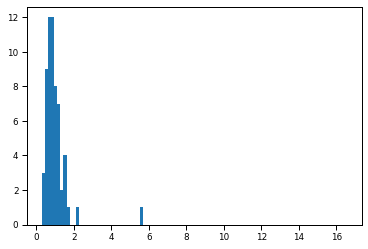

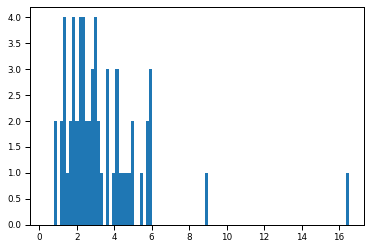

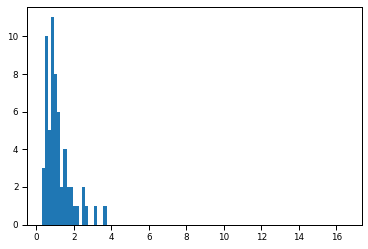

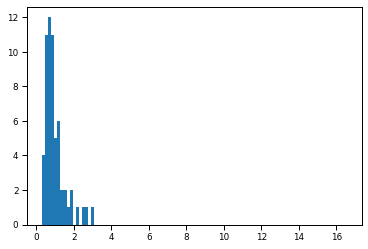

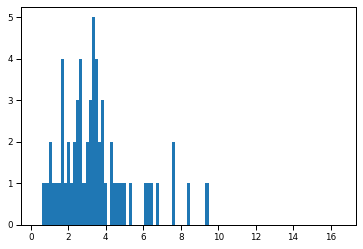

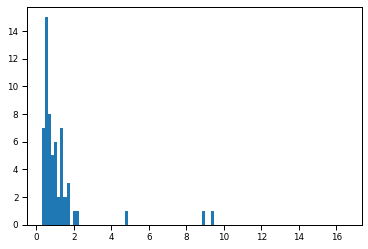


Control group:
5 of 6 rc regions significantly (5%) differ from a normal distribution.


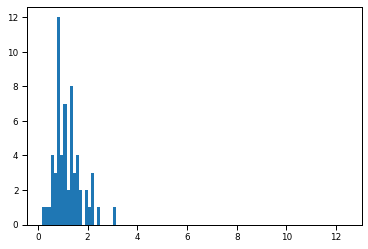

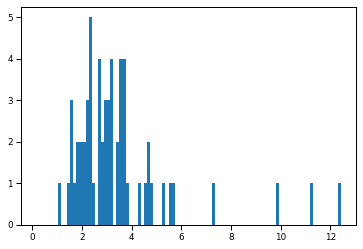

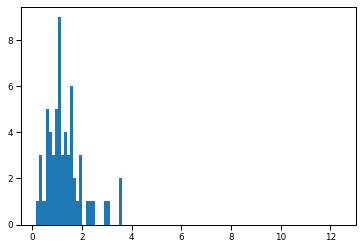

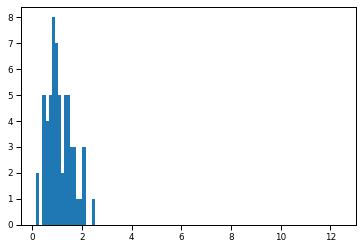

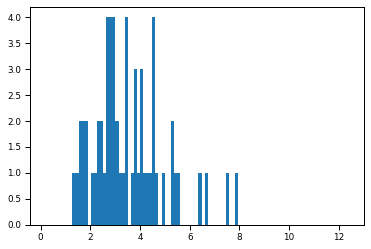

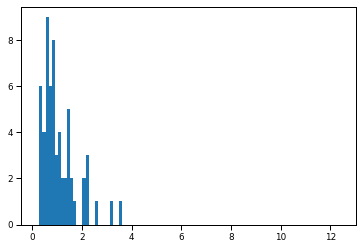

In [15]:
## Test feeder io ratio for normal distribution
def test_for_normal_dist(array_2D):
    n_subjects = np.fmin(n_patients, n_controls)
    array_2D = array_2D[:n_subjects]
    significance_level_ind = 2
    significance_level = stt.anderson(
        np.ones(2)).significance_level[significance_level_ind]
    anderson_results = np.array([stt.anderson(dist).statistic
                        > stt.anderson(dist).critical_values[2]
                                 for dist in array_2D.T], dtype=bool)
    print(np.array(np.where(anderson_results)).shape[1], 'of', 
          array_2D.shape[1], str('rc regions significantly ('
                                 + str(int(significance_level)) + '%)'), 
          'differ from a normal distribution.')
    [(plt.figure(), plt.hist(dist, bins=np.linspace(
        array_2D.min(), array_2D.max(), 100))) for dist in array_2D.T ]
    plt.show()
## Test each subject's data as a whole on normal distribution
#anderson2 = np.array([(stt.anderson(x).statistic > stt.anderson(x).critical_values[2]) for x in ts_patients.reshape(n_patients, -1)], dtype=bool)
#print(anderson2.shape)
#np.array(np.where(anderson2)).shape
print(black('\nPatient group:', 'bold'))
test_for_normal_dist(io_ratio_rc_patients)
print(black('\nControl group:', 'bold'))
test_for_normal_dist(io_ratio_rc_controls)


Patient group:
4 of 6 rc regions significantly (5%) differ from a normal distribution.


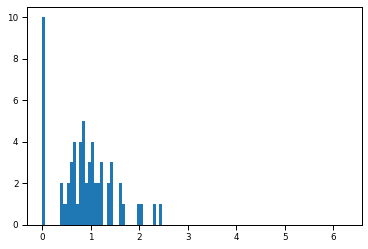

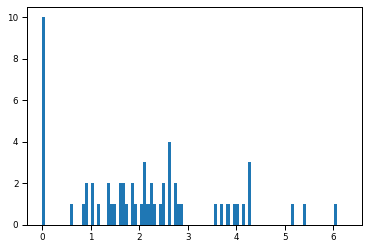

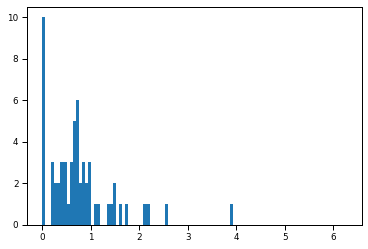

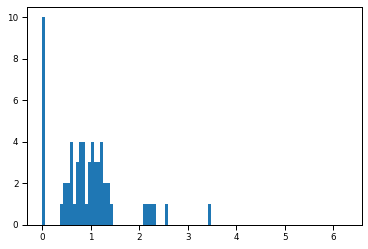

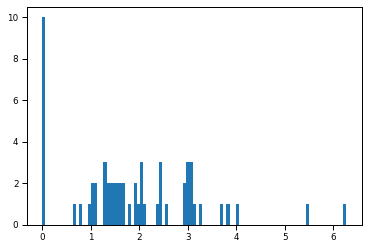

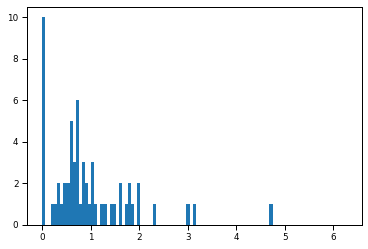


Control group:
6 of 6 rc regions significantly (5%) differ from a normal distribution.


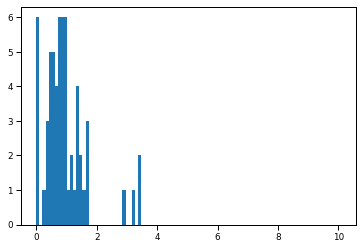

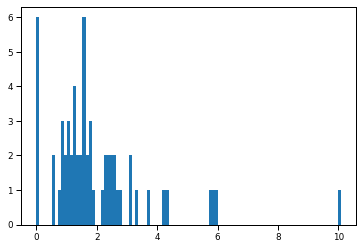

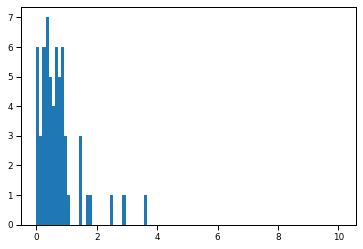

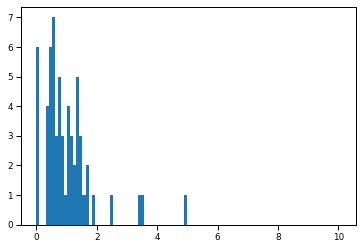

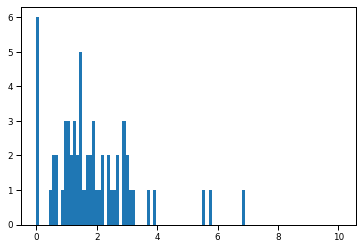

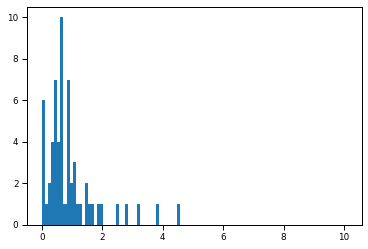

In [16]:
## Test inputs for normal distribution.
input_rc_patients = input_patients[:, mask_rc]
input_rc_controls = input_controls[:, mask_rc]
print(black('\nPatient group:', 'bold'))
test_for_normal_dist(input_rc_patients)
print(black('\nControl group:', 'bold'))
test_for_normal_dist(input_rc_controls)

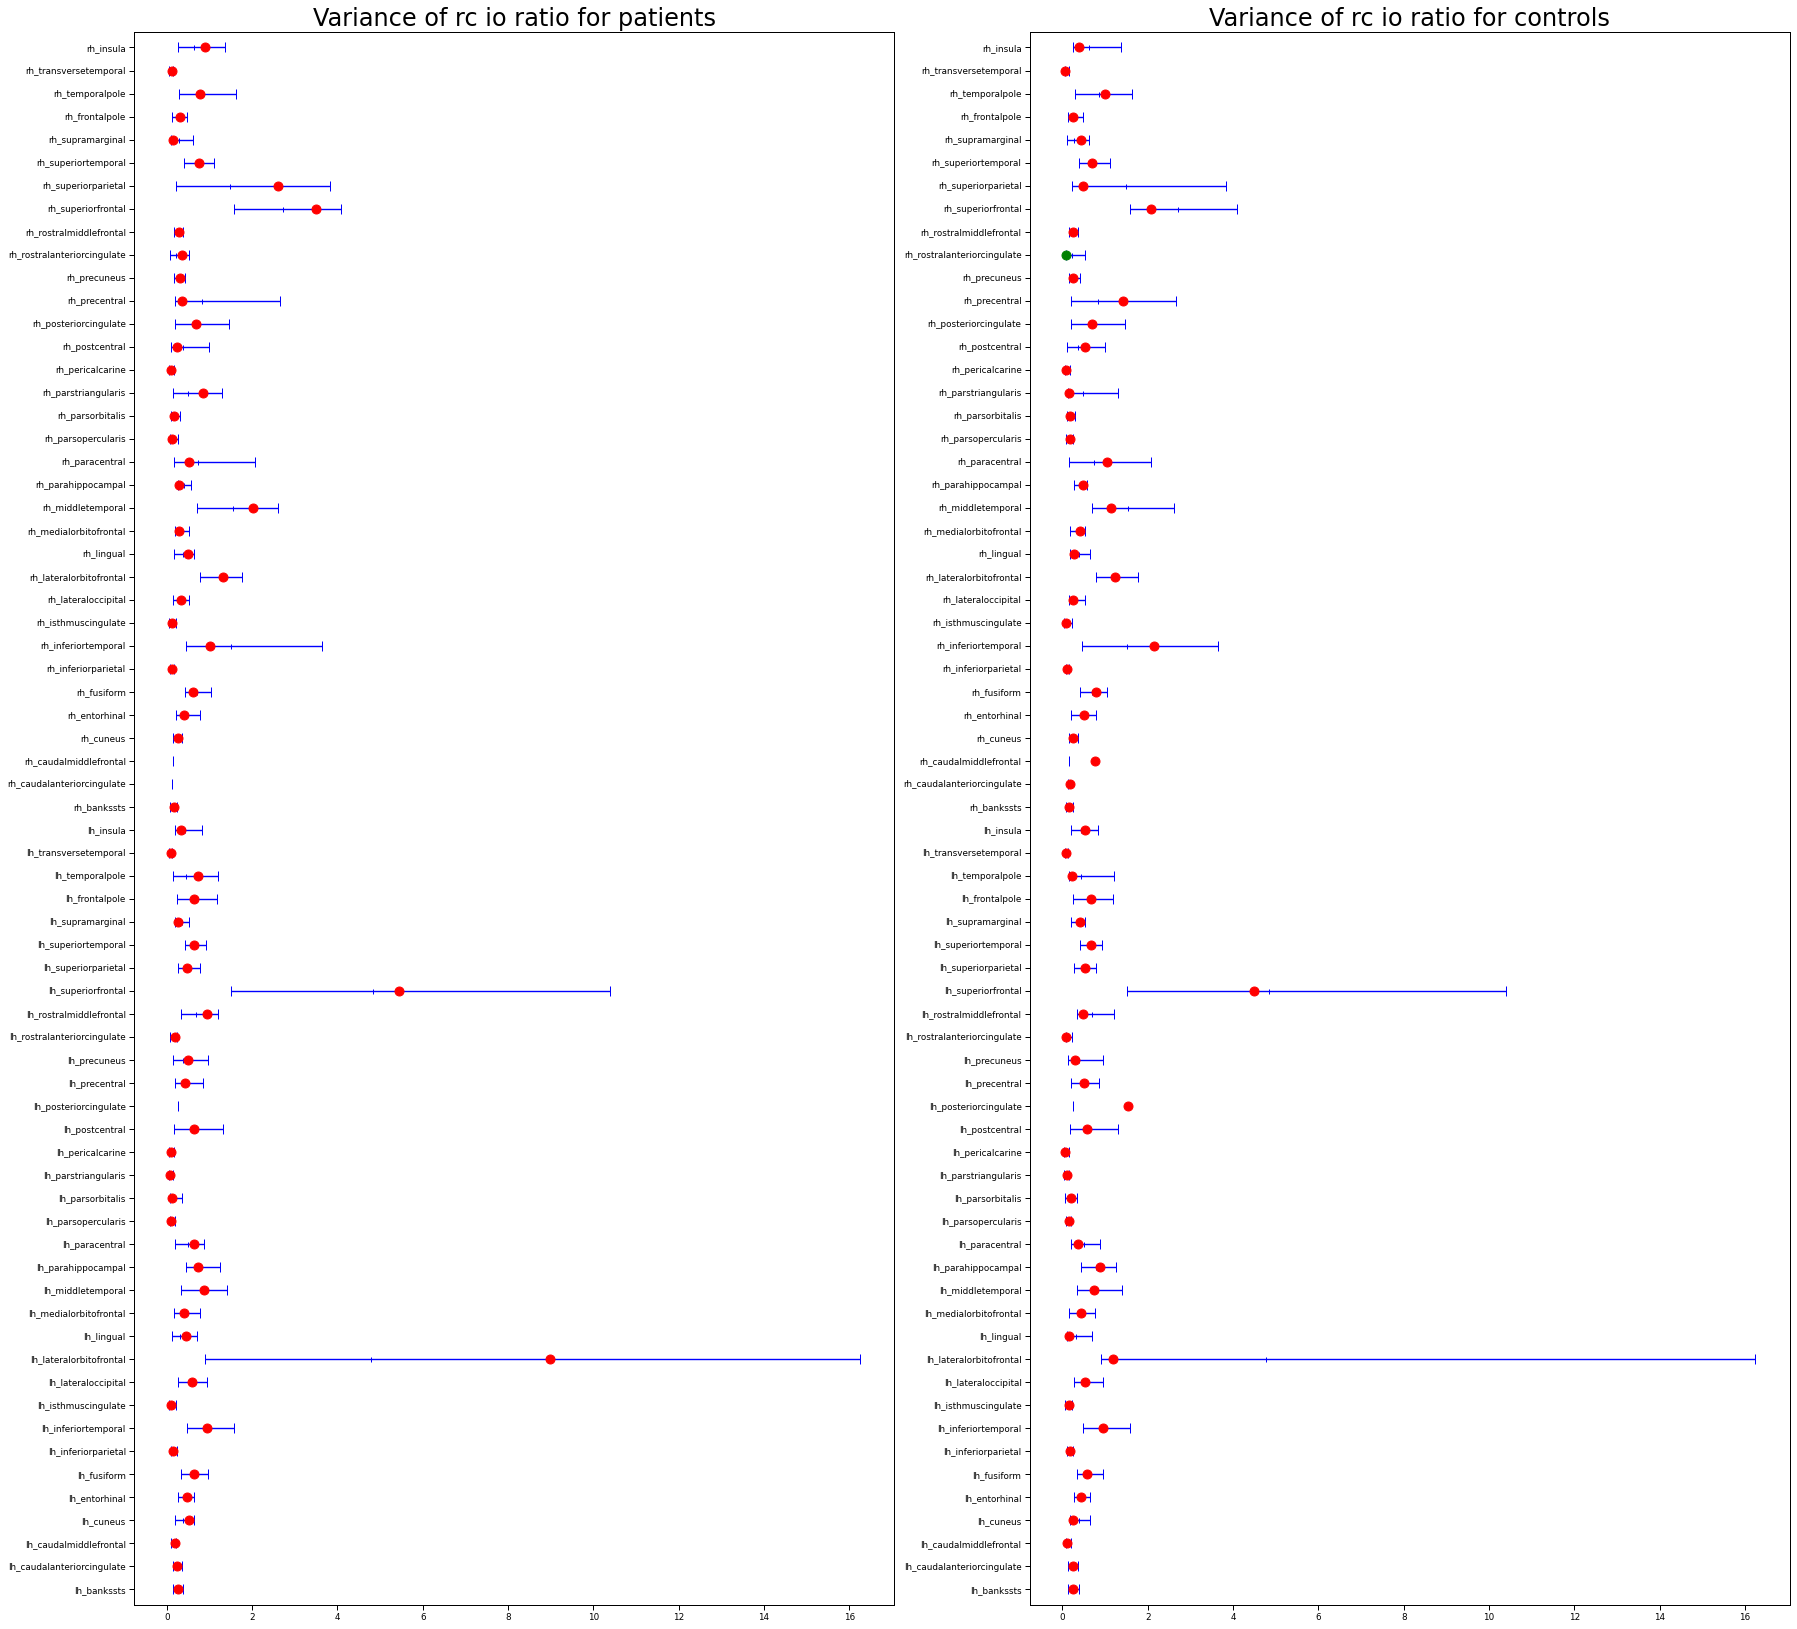

In [40]:
## Examine significance of variance of rc io ratio (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Variance of rc io ratio'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(io_ratio_patients, io_ratio_controls,
                         np.var(io_ratio_patients[:n_subjects], axis=0),
                         np.var(io_ratio_controls[:n_subjects], axis=0),
                         statistic_description, y_labels, alpha, np.var)
else:
    examine_significance(io_ratio_patients, io_ratio_controls,
                         np.var(io_ratio_patients, axis=0),
                         np.var(io_ratio_controls, axis=0),
                         statistic_description, y_labels, alpha, np.var)

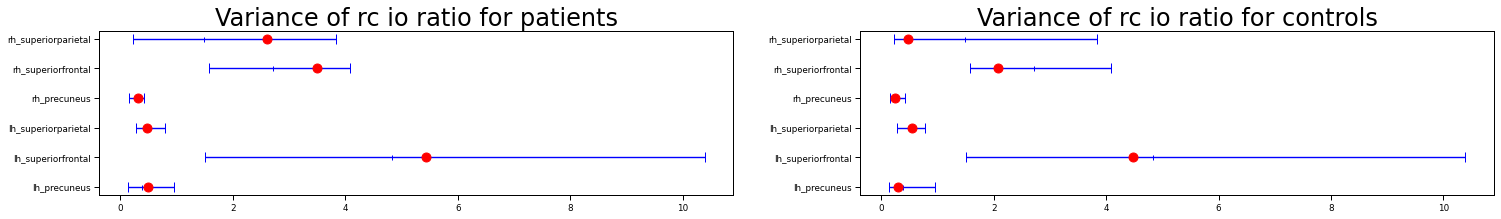

In [17]:
## Examine significance of variance of rc io ratio (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Variance of rc io ratio'
y_labels = roi_labels[indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(io_ratio_rc_patients, io_ratio_rc_controls,
                         np.var(io_ratio_rc_patients[:n_subjects], axis=0),
                         np.var(io_ratio_rc_controls[:n_subjects], axis=0),
                         statistic_description, y_labels, alpha, np.var)
else:
    examine_significance(io_ratio_rc_patients, io_ratio_rc_controls,
                         np.var(io_ratio_rc_patients, axis=0),
                         np.var(io_ratio_rc_controls, axis=0),
                         statistic_description, y_labels, alpha, np.var)

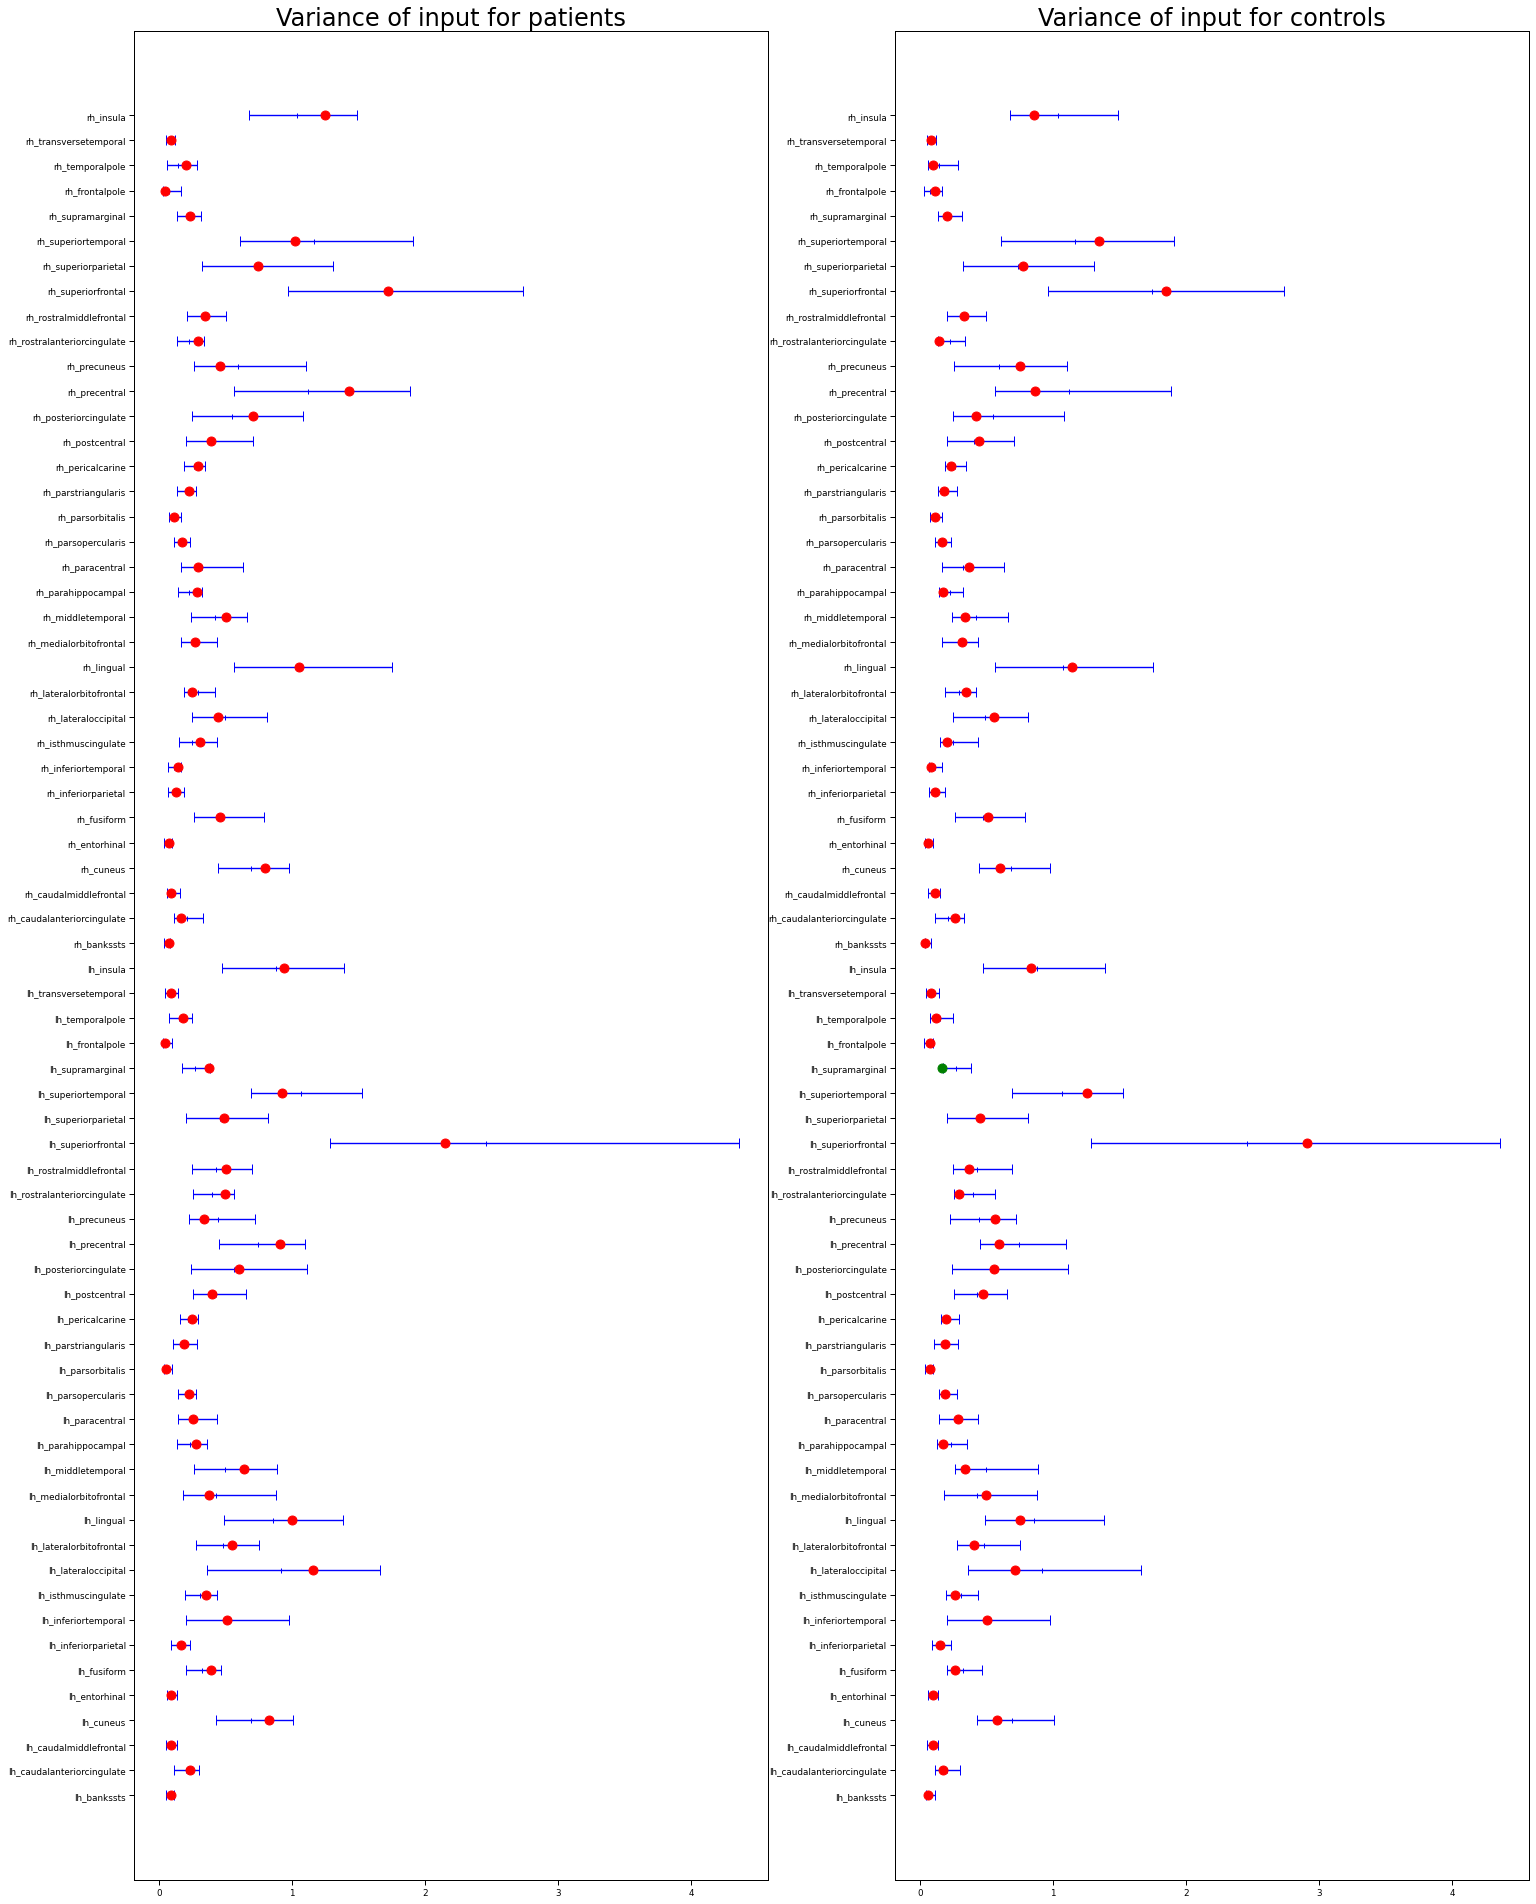

46

In [18]:
## Examine significance of variance of rc input (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Variance of input'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(input_patients,
                             input_controls,
                             np.var(input_patients[:n_subjects, :], axis=0),
                             np.var(input_controls[:n_subjects, :], axis=0),
                             statistic_description, y_labels, alpha, np.var)
else:
    examine_significance(input_patients,
                             input_controls,
                             np.var(input_patients, axis=0),
                             np.var(input_controls, axis=0),
                             statistic_description, y_labels, alpha, np.var)
    
len(np.nonzero(np.var(input_patients, axis=0)>np.var(input_controls, axis=0))[0])

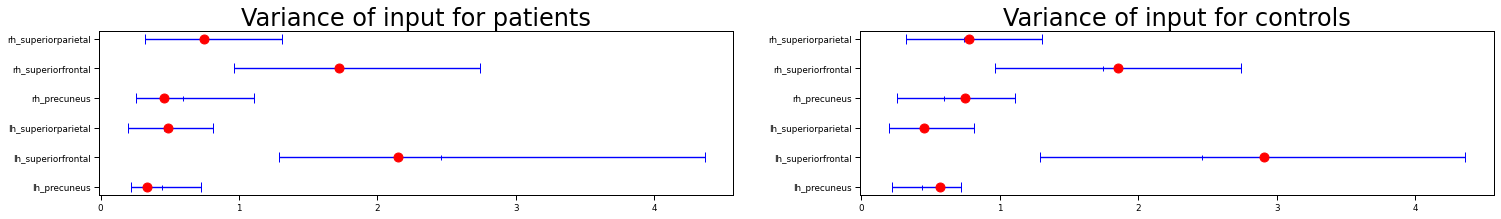

In [19]:
## Examine significance of variance of rc input (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Variance of input'
y_labels = roi_labels[indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(input_patients[:, mask_rc],
                             input_controls[:, mask_rc],
                             np.var(input_patients[:n_subjects, mask_rc], axis=0),
                             np.var(input_controls[:n_subjects, mask_rc], axis=0),
                             statistic_description, y_labels, alpha, np.var)
else:
    examine_significance(input_patients[:, mask_rc],
                             input_controls[:, mask_rc],
                             np.var(input_patients[:, mask_rc], axis=0),
                             np.var(input_controls[:, mask_rc], axis=0),
                             statistic_description, y_labels, alpha, np.var)

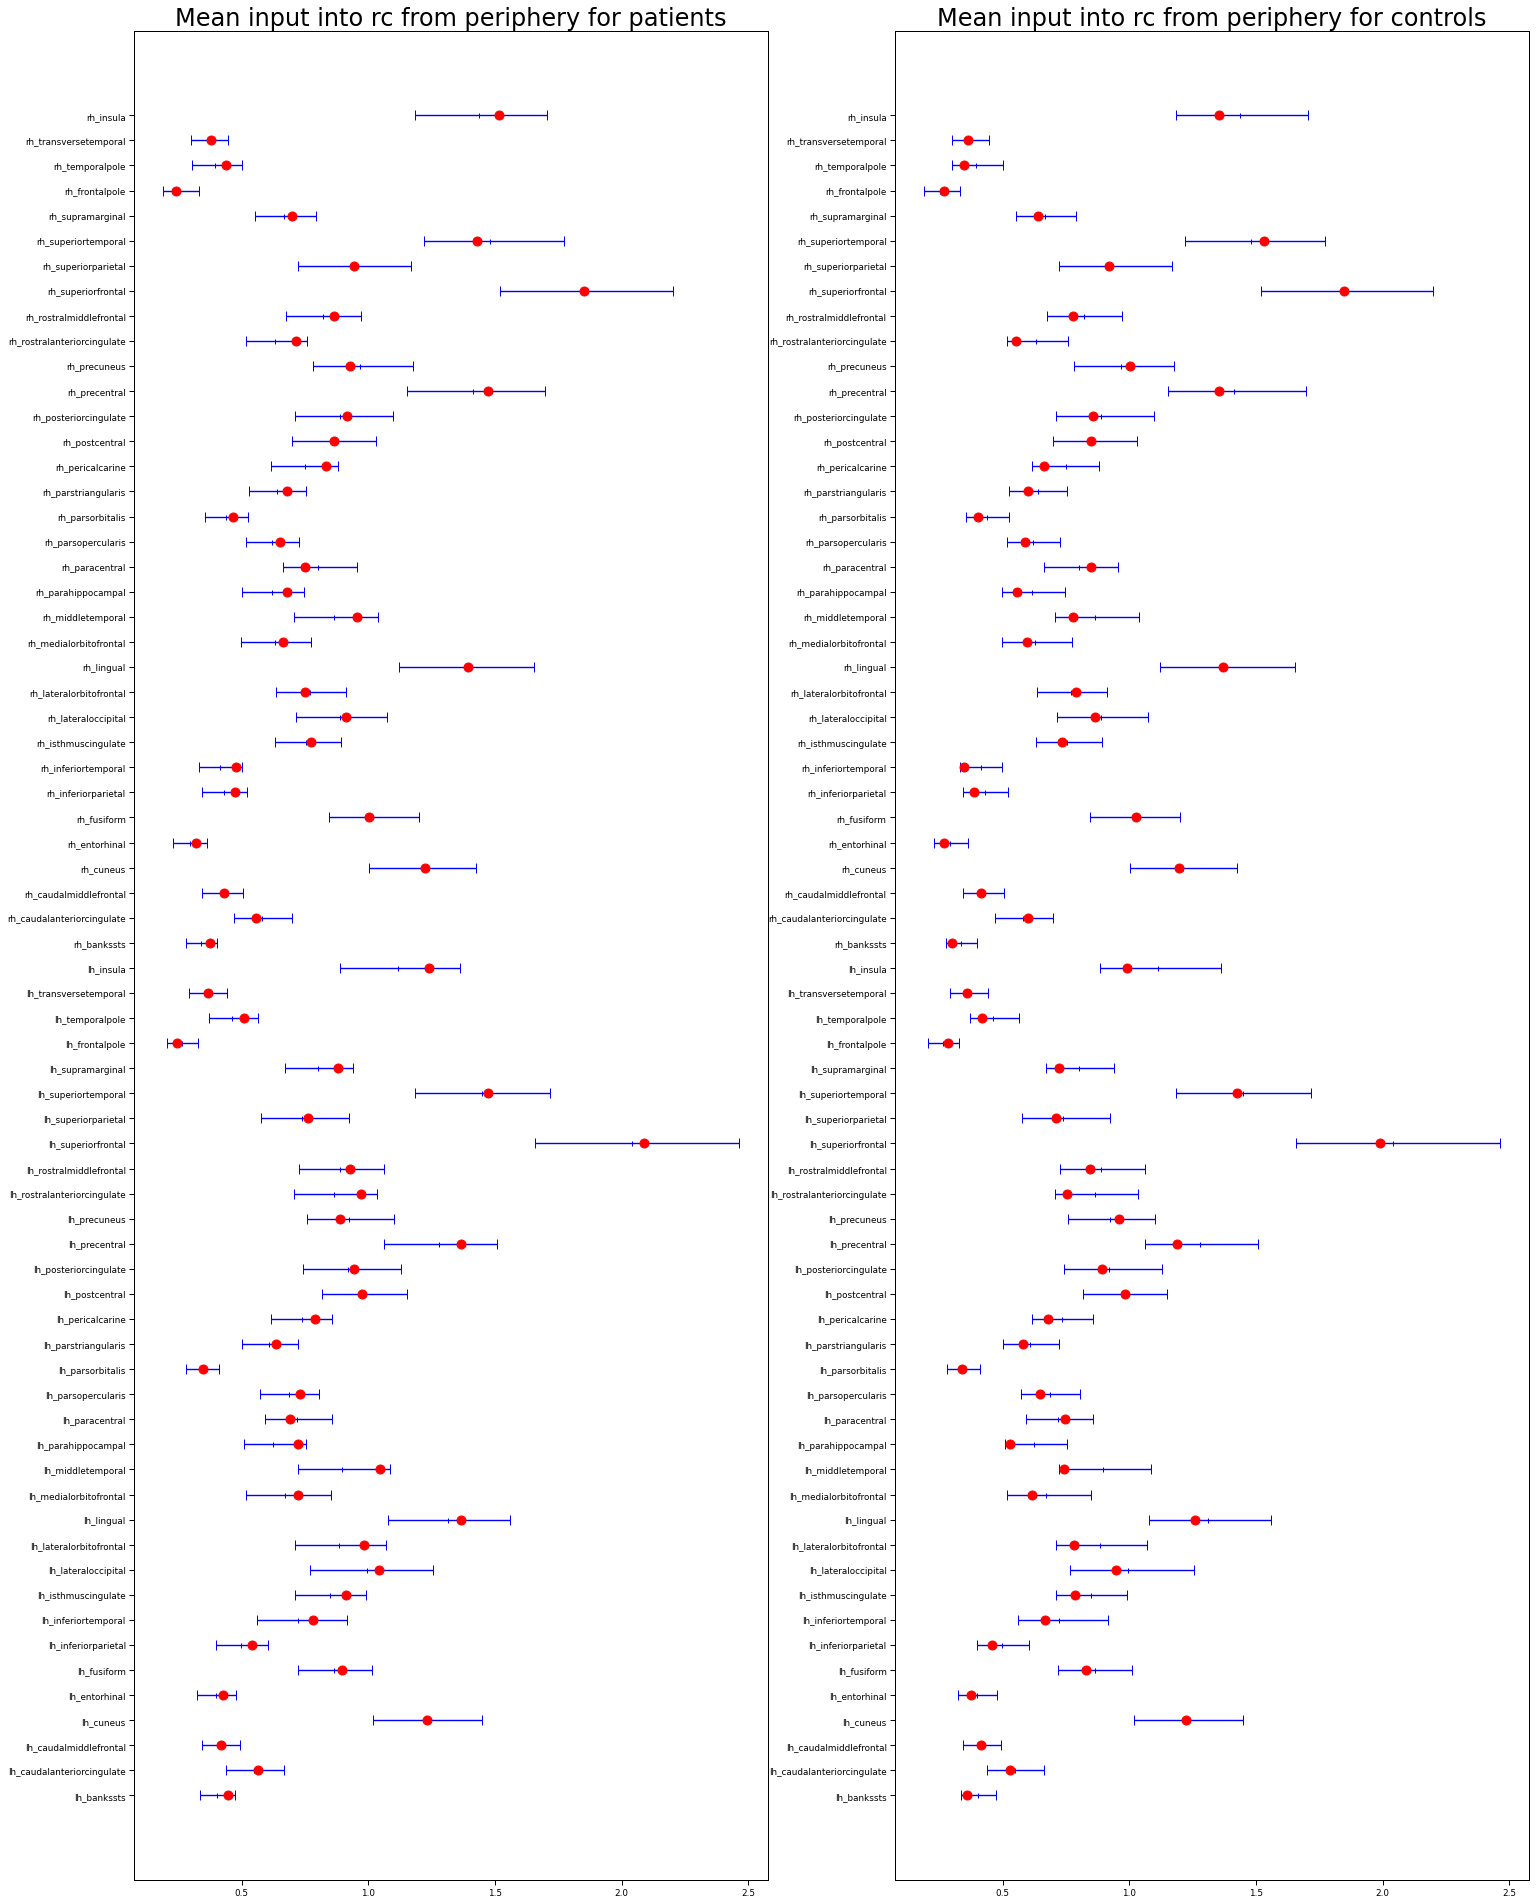

In [20]:
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Mean input into rc from periphery'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(input_patients[:n_subjects],
                              input_controls[:n_subjects],
                              input_patients[:n_subjects].mean(axis=0),
                              input_controls[:n_subjects].mean(axis=0),
                              statistic_description, y_labels, alpha, np.mean)
else:
    examine_significance(input_patients, input_controls,
                              input_patients.mean(axis=0),
                              input_controls.mean(axis=0),
                              statistic_description, y_labels, alpha, np.mean)

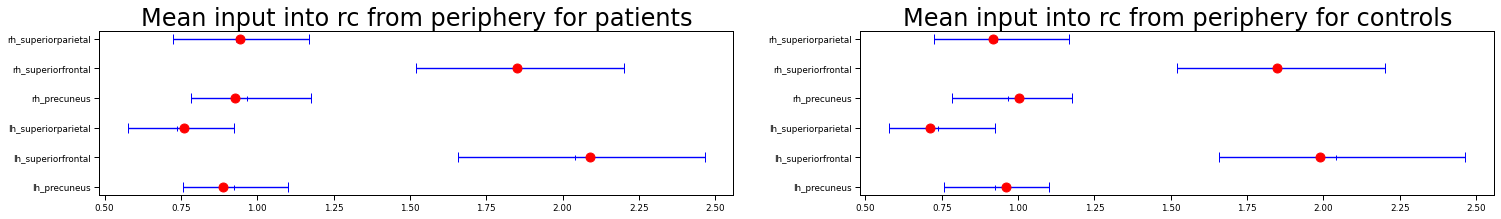

In [21]:
## Examine significance of mean of rc input (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Mean input into rc from periphery'
y_labels = roi_labels[indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(input_rc_patients[:n_subjects],
                              input_rc_controls[:n_subjects],
                              input_rc_patients[:n_subjects].mean(axis=0),
                              input_rc_controls[:n_subjects].mean(axis=0),
                              statistic_description, y_labels, alpha, np.mean)
else:
    examine_significance(input_rc_patients, input_rc_controls,
                              input_rc_patients.mean(axis=0),
                              input_rc_controls.mean(axis=0),
                              statistic_description, y_labels, alpha, np.mean)

<ipython-input-38-cfd901c3277a>:6: RuntimeWarning: invalid value encountered in true_divide
  io_ratio_patients = input_patients/output_patients


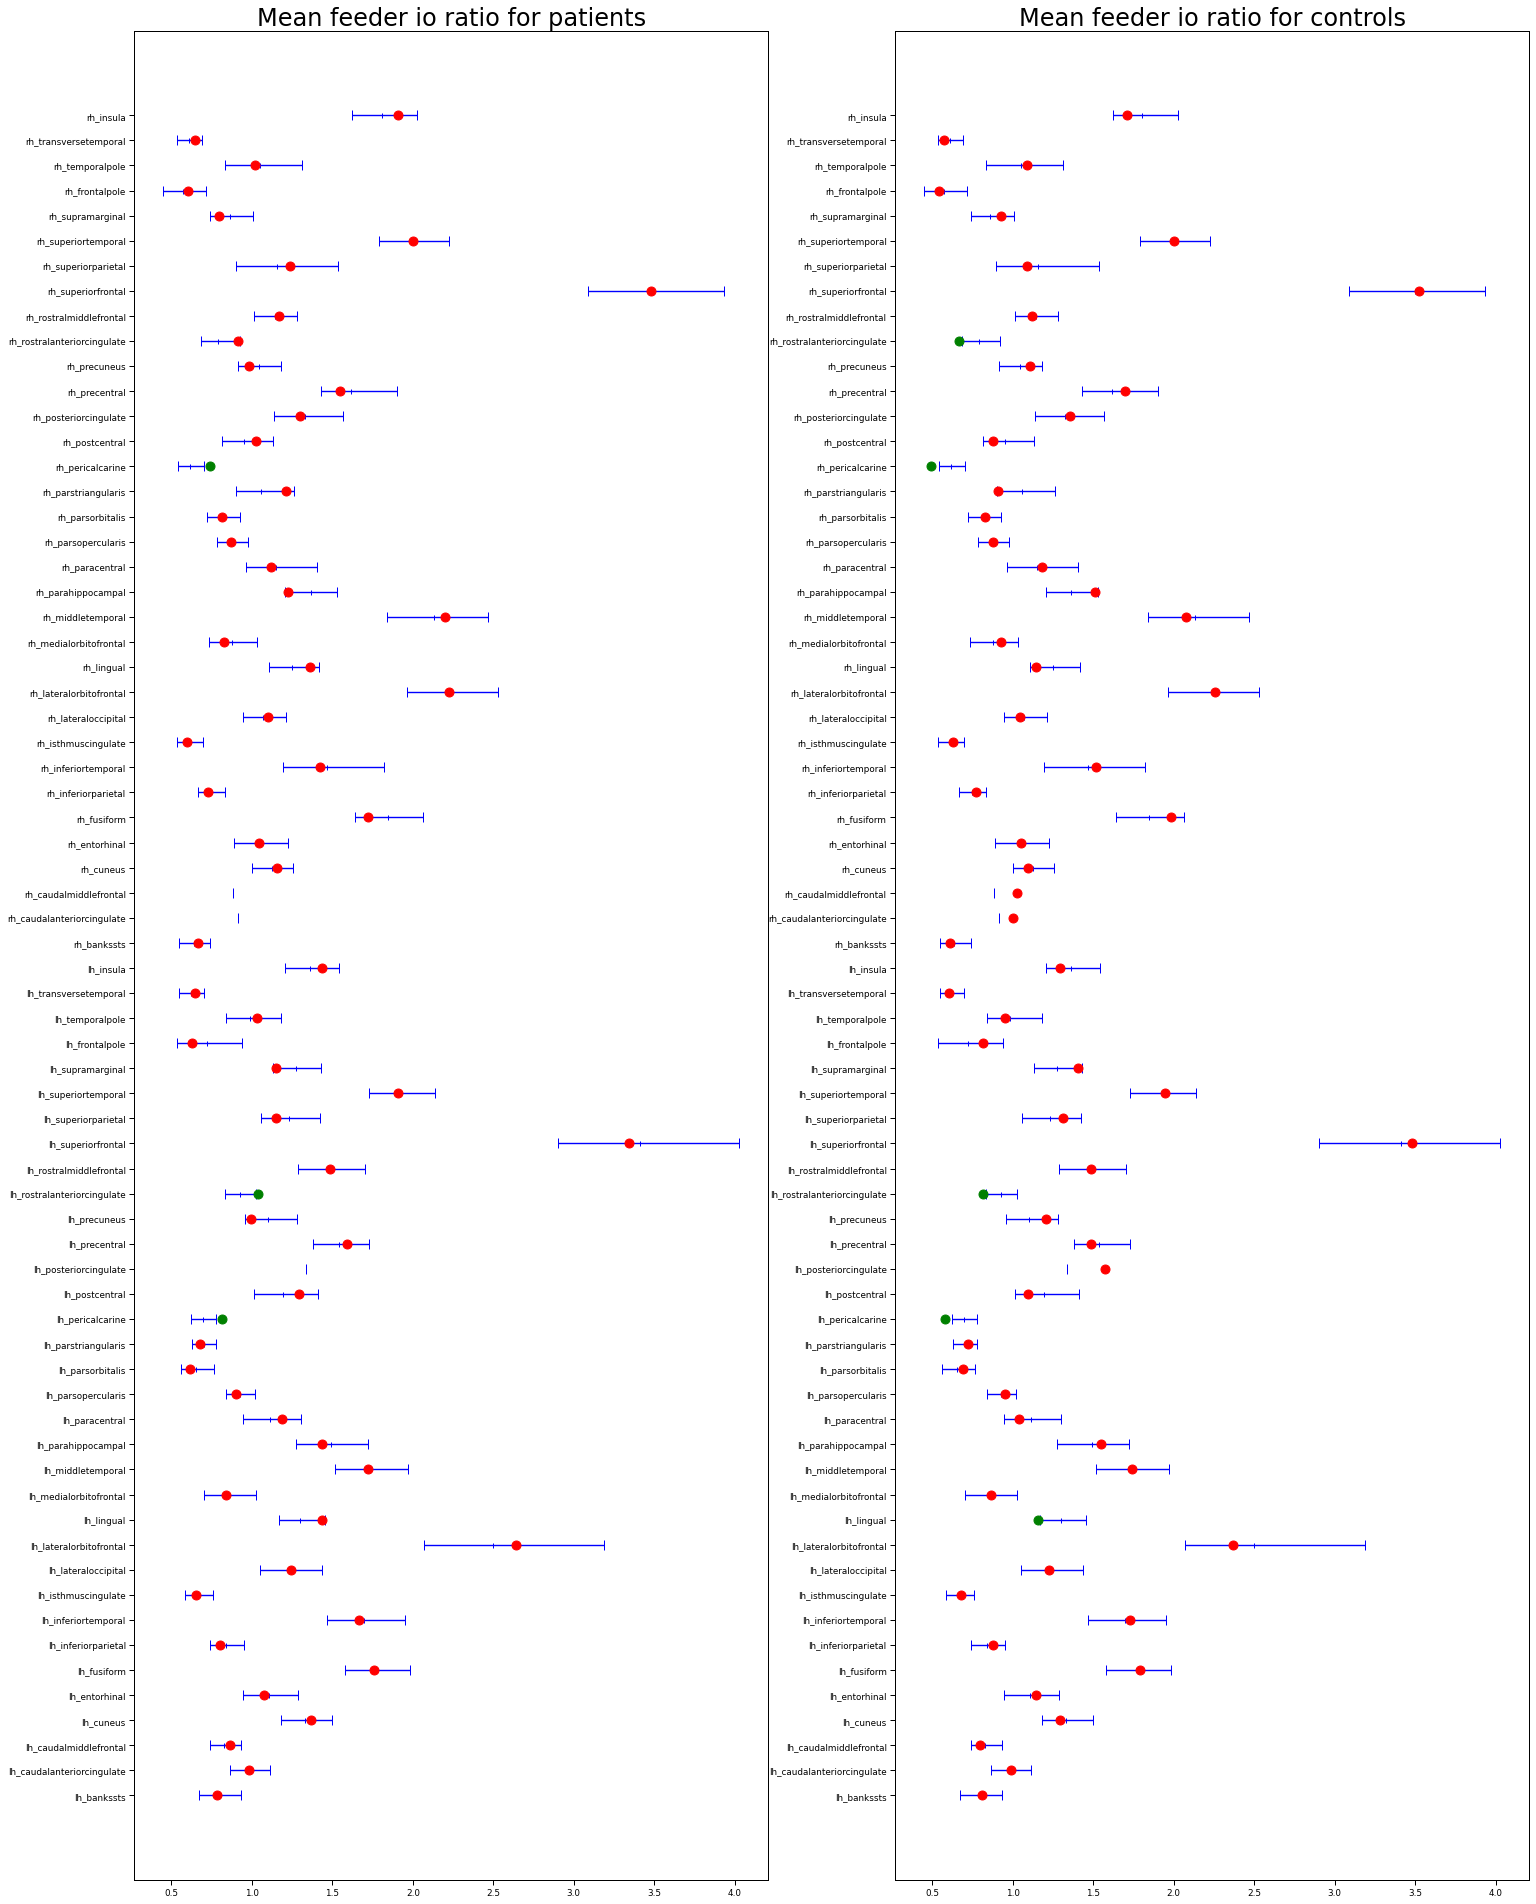

In [38]:
## Examine significance of mean of io ratio (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Mean feeder io ratio'
y_labels = roi_labels
io_ratio_patients = input_patients/output_patients
io_ratio_controls = input_controls/output_controls
sample_groupsize = 'matched'
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(io_ratio_patients,
                              io_ratio_controls,
                              io_ratio_patients[:n_subjects].mean(axis=0),
                              io_ratio_controls[:n_subjects].mean(axis=0),
                              statistic_description, y_labels, alpha, np.mean)
else:
    examine_significance(io_ratio_patients, io_ratio_controls,
                              io_ratio_patients.mean(axis=0),
                              io_ratio_controls.mean(axis=0),
                              statistic_description, y_labels, alpha, np.mean)

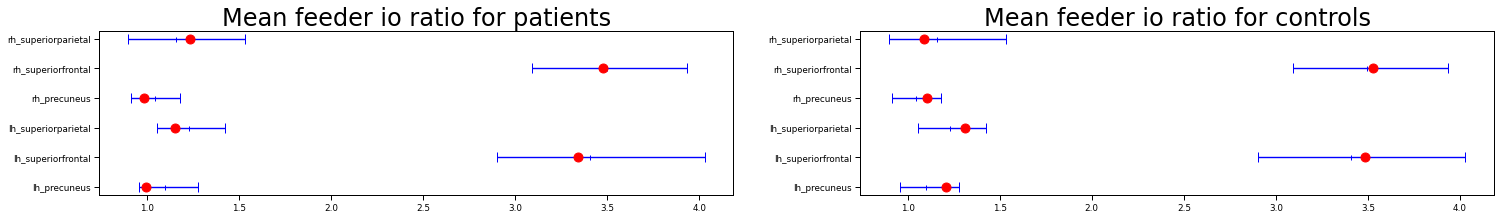

In [23]:
## Examine significance of mean of io ratio (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Mean feeder io ratio'
y_labels = roi_labels[indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(io_ratio_rc_patients,
                              io_ratio_rc_controls,
                              io_ratio_rc_patients[:n_subjects].mean(axis=0),
                              io_ratio_rc_controls[:n_subjects].mean(axis=0),
                              statistic_description, y_labels, alpha, np.mean)
else:
    examine_significance(io_ratio_rc_patients, io_ratio_rc_controls,
                              io_ratio_rc_patients.mean(axis=0),
                              io_ratio_rc_controls.mean(axis=0),
                              statistic_description, y_labels, alpha, np.mean)

Input: Examine the subjects responsible for the largest value per region:
RC-indexes:
 [23 26 27 57 60 61]
Investigate input and output regionwise for RC-periphery (feeder) connections:
Patients:

input_Counter_subjects_total_patients:
 Counter({12: 14, 21: 12, 5: 12, 46: 9, 7: 4, 3: 4, 37: 3, 0: 2, 23: 2, 50: 2, 11: 1, 31: 1, 29: 1, 35: 1})

input_Counter_subjects_total_controls:
 Counter({46: 18, 57: 17, 8: 17, 5: 4, 38: 3, 21: 3, 7: 3, 33: 2, 47: 1})


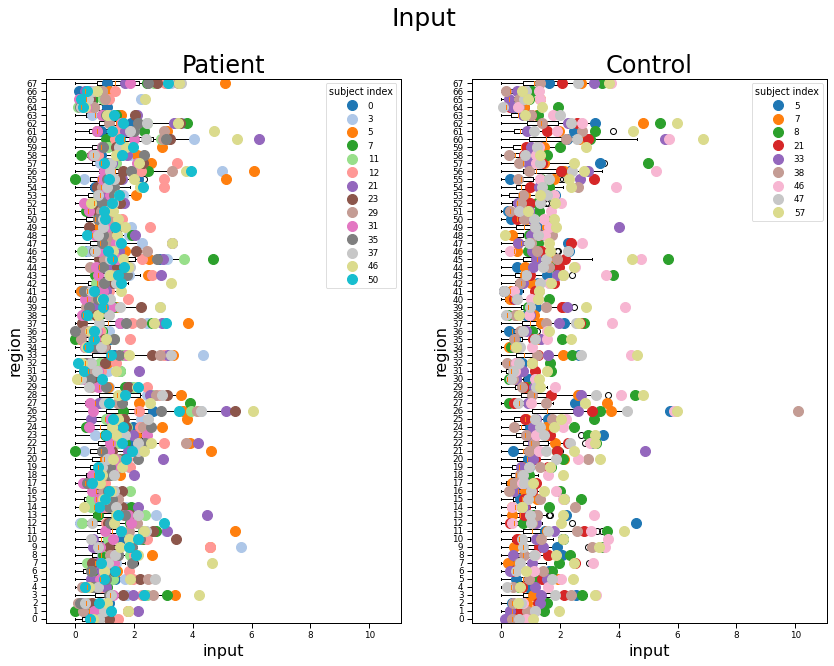

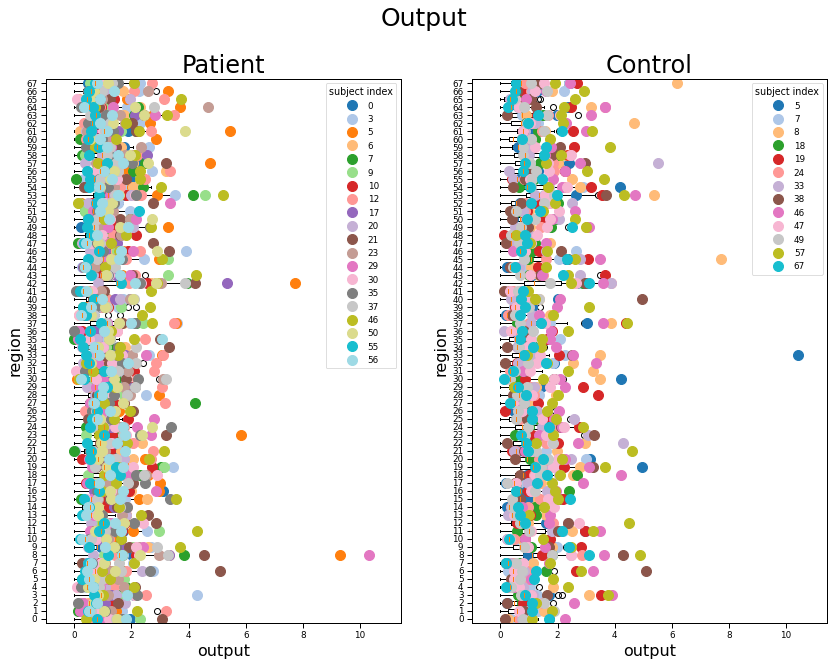

output_Counter_subjects_total_patients:
 Counter({46: 13, 12: 12, 5: 10, 21: 8, 3: 5, 29: 3, 37: 3, 9: 2, 20: 1, 0: 1, 30: 1, 6: 1, 35: 1, 7: 1, 56: 1, 10: 1, 50: 1, 55: 1, 17: 1, 23: 1})
output_Counter_subjects_total_controls:
 Counter({57: 22, 46: 13, 8: 6, 19: 5, 5: 5, 33: 5, 38: 3, 47: 3, 7: 2, 49: 1, 67: 1, 18: 1, 24: 1})
Mean rc input:	 0.8316169937519278 (patients)	 0.754484797162674 (contols)


In [24]:
"""
Patients: Analyse input from the periphery into the rc with regard
to max values. 
"""

n_max_values = 1
# Find subjects responsible for the outliers.
print(black('Input: Examine the subjects responsible for the largest value per region:', 'bold'))
input_Counter_subjects_total_patients = Counter()
input_Counter_rois_total_patients = Counter()
output_Counter_subjects_total_patients = Counter()
output_Counter_rois_total_patients = Counter()
for i_max in range(n_max_values):
    condition = input_patients.T == np.outer(np.sort(
        input_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
    input_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    input_Counter_subjects_total_patients += input_Counter_subjects

## Analyse rc output with regard to max values.
# Find subjects responsible for the outliers.
for i_max in range(n_max_values):
    condition = output_patients.T == np.outer(np.sort(
        output_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
    output_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    output_Counter_subjects_total_patients += output_Counter_subjects
    
input_Counter_subjects_total_controls = Counter()
input_Counter_rois_total_controls = Counter()
output_Counter_subjects_total_controls = Counter()
output_Counter_rois_total_controls = Counter()
for i_max in range(n_max_values):
    condition = input_controls.T == np.outer(np.sort(
        input_controls, axis=0)[-i_max-1, :], np.ones([n_controls]))
    input_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    input_Counter_subjects_total_controls += input_Counter_subjects

## Analyse rc output with regard to max values.
# Find subjects responsible for the outliers.
for i_max in range(n_max_values):
    condition = output_controls.T == np.outer(np.sort(
        output_controls, axis=0)[-i_max-1, :], np.ones([n_controls]))
    output_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    output_Counter_subjects_total_controls += output_Counter_subjects

    
## Plot feeder input and output and color subjects who have the 1st, 2nd and 3rd maximal values.
suptitle_fontsize = 25
title_fontsize = 24
axis_lable_fontsize = 16
fontsize = 15
top_adjust = 0.88
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(red('Investigate input and output regionwise for RC-periphery'
          ' (feeder) connections:', 'bold'))

#plot_feeder_io_boxplot(input_patients, output_patients, 'Patients')
#plot_feeder_io_boxplot(input_controls, output_controls, 'Controls')
print(black('Patients:', 'bold'))
print('\ninput_Counter_subjects_total_patients:\n', input_Counter_subjects_total_patients)
print('\ninput_Counter_subjects_total_controls:\n', input_Counter_subjects_total_controls)
plot_feeder_io_group_comparing_boxplot(
    input_patients, output_patients, input_controls, output_controls, 'tab20')
print('output_Counter_subjects_total_patients:\n', output_Counter_subjects_total_patients)
print('output_Counter_subjects_total_controls:\n', output_Counter_subjects_total_controls)
print('Mean rc input:\t', input_patients.mean(),
  '(patients)\t', input_controls.mean(), '(contols)')

In [25]:
## Investigate per subject.
input_rc_patients = input_patients[:, indexes_rc]
input_rc_controls = input_controls[:, indexes_rc]
output_rc_patients = output_patients[:, indexes_rc]
output_rc_controls = output_controls[:, indexes_rc]
io_ratio_rc_patients = input_rc_patients/output_rc_patients
io_ratio_rc_controls = input_rc_controls/output_rc_controls

## 1st moment (mean).
print(black('1st moment:', 'bold'))
# Input:
print(black('\tPatients: Input:', 'bold'), 'Feeder connections:\n\t\t', input_rc_patients.mean(axis=0))
print(black('\tControls: Input:', 'bold'), 'Feeder connections:\n\t\t', input_rc_controls.mean(axis=0))
print(black('\tPatients: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', input_rc_patients.mean())
print(black('\tControls: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', input_rc_controls.mean())
# Output:
print(black('\tPatients: Output:', 'bold'), 'Feeder connections:\n\t\t', output_rc_patients.mean(axis=0))
print(black('\tControls: Output:', 'bold'), 'Feeder connections:\n\t\t', output_rc_controls.mean(axis=0))
print(black('\tPatients: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', output_rc_patients.mean())
print(black('\tControls: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', output_rc_controls.mean())
# io ratio:
print(black('\tPatients: io ratio:', 'bold'), 'Feeder connections:\n\t\t', io_ratio_rc_patients.mean(axis=0))
print(black('\tControls: io ratio:', 'bold'), 'Feeder connections:\n\t\t', io_ratio_rc_controls.mean(axis=0))
print(black('\tPatients: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', io_ratio_rc_patients.mean())
print(black('\tControls: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', io_ratio_rc_controls.mean())

## 2nd moment (variance).
print(black('2nd moment:', 'bold'))
# Input:
print(black('\tPatients: Input:', 'bold'), 'Feeder connections:\n\t\t', input_rc_patients.var(axis=0))
print(black('\tControls: Input:', 'bold'), 'Feeder connections:\n\t\t', input_rc_controls.var(axis=0))
print(black('\tPatients: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', input_rc_patients.var())
print(black('\tControls: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', input_rc_controls.var())
# Output:
print(black('\tPatients: Output:', 'bold'), 'Feeder connections:\n\t\t', output_rc_patients.var(axis=0))
print(black('\tControls: Output:', 'bold'), 'Feeder connections:\n\t\t', output_rc_controls.var(axis=0))
print(black('\tPatients: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', output_rc_patients.var())
print(black('\tControls: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', output_rc_controls.var())
# io ratio:
print(black('\tPatients: io ratio:', 'bold'), 'Feeder connections:\n\t\t', io_ratio_rc_patients.var(axis=0))
print(black('\tControls: io ratio:', 'bold'), 'Feeder connections:\n\t\t', io_ratio_rc_controls.var(axis=0))
print(black('\tPatients: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', io_ratio_rc_patients.var())
print(black('\tControls: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', io_ratio_rc_controls.var())

## 3rd moment (skewness).
print(black('3rd moment:', 'bold'))
# Input:
print(black('\tPatients: Input:', 'bold'), 'Feeder connections:\n\t\t', stt.skew(input_rc_patients, axis=0))
print(black('\tControls: Input:', 'bold'), 'Feeder connections:\n\t\t', stt.skew(input_rc_controls, axis=0))
print(black('\tPatients: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.skew(input_rc_patients.reshape(-1)))
print(black('\tControls: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.skew(input_rc_controls.reshape(-1)))
# Output:
print(black('\tPatients: Output:', 'bold'), 'Feeder connections:\n\t\t', stt.skew(output_rc_patients, axis=0))
print(black('\tControls: Output:', 'bold'), 'Feeder connections:\n\t\t', stt.skew(output_rc_controls, axis=0))
print(black('\tPatients: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.skew(output_rc_patients.reshape(-1)))
print(black('\tControls: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.skew(output_rc_controls.reshape(-1)))
# io ratio:
print(black('\tPatients: io ratio:', 'bold'), 'Feeder connections:\n\t\t', stt.skew(io_ratio_rc_patients, axis=0))
print(black('\tControls: io ratio:', 'bold'), 'Feeder connections:\n\t\t', stt.skew(io_ratio_rc_controls, axis=0))
print(black('\tPatients: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.skew(io_ratio_rc_patients.reshape(-1)))
print(black('\tControls: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.skew(io_ratio_rc_controls.reshape(-1)))

## 4th moment (skewness).
print(black('4th moment:', 'bold'))
# Input:
print(black('\tPatients: Input:', 'bold'), 'Feeder connections:\n\t\t', stt.kurtosis(input_rc_patients, axis=0))
print(black('\tControls: Input:', 'bold'), 'Feeder connections:\n\t\t', stt.kurtosis(input_rc_controls, axis=0))
print(black('\tPatients: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.kurtosis(input_rc_patients.reshape(-1)))
print(black('\tControls: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.kurtosis(input_rc_controls.reshape(-1)))
# Output:
print(black('\tPatients: Output:', 'bold'), 'Feeder connections:\n\t\t', stt.kurtosis(output_rc_patients, axis=0))
print(black('\tControls: Output:', 'bold'), 'Feeder connections:\n\t\t', stt.kurtosis(output_rc_controls, axis=0))
print(black('\tPatients: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.kurtosis(output_rc_patients.reshape(-1)))
print(black('\tControls: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.kurtosis(output_rc_controls.reshape(-1)))
# io ratio:
print(black('\tPatients: io ratio:', 'bold'), 'Feeder connections:\n\t\t', stt.kurtosis(io_ratio_rc_patients, axis=0))
print(black('\tControls: io ratio:', 'bold'), 'Feeder connections:\n\t\t', stt.kurtosis(io_ratio_rc_controls, axis=0))
print(black('\tPatients: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.kurtosis(io_ratio_rc_patients.reshape(-1)))
print(black('\tControls: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.kurtosis(io_ratio_rc_controls.reshape(-1)))

1st moment:
	Patients: Input: Feeder connections:
		 [0.88690073 2.09031006 0.76055536 0.92819803 1.84995325 0.94207567]
	Controls: Input: Feeder connections:
		 [0.96588968 1.97288067 0.69890193 0.99668595 1.83905856 0.9081683 ]
	Patients: Input: Over all feeder connections and all subjects:
		 1.242998851860256
	Controls: Input: Over all feeder connections and all subjects:
		 1.2302641812702884
	Patients: Output: Feeder connections:
		 [1.06931492 0.68534266 0.71998071 1.07025943 0.57302303 1.09313872]
	Controls: Output: Feeder connections:
		 [0.86820847 0.60050433 0.53786851 0.99282831 0.52333561 0.9221554 ]
	Patients: Output: Over all feeder connections and all subjects:
		 0.8685099132449654
	Controls: Output: Over all feeder connections and all subjects:
		 0.7408167714980302
	Patients: io ratio: Feeder connections:
		 [0.99418408 3.34300073 1.15264044 0.98328391 3.47838676 1.23445129]
	Controls: io ratio: Feeder connections:
		 [1.21506979 3.35906351 1.3660765  1.09221255 3.42

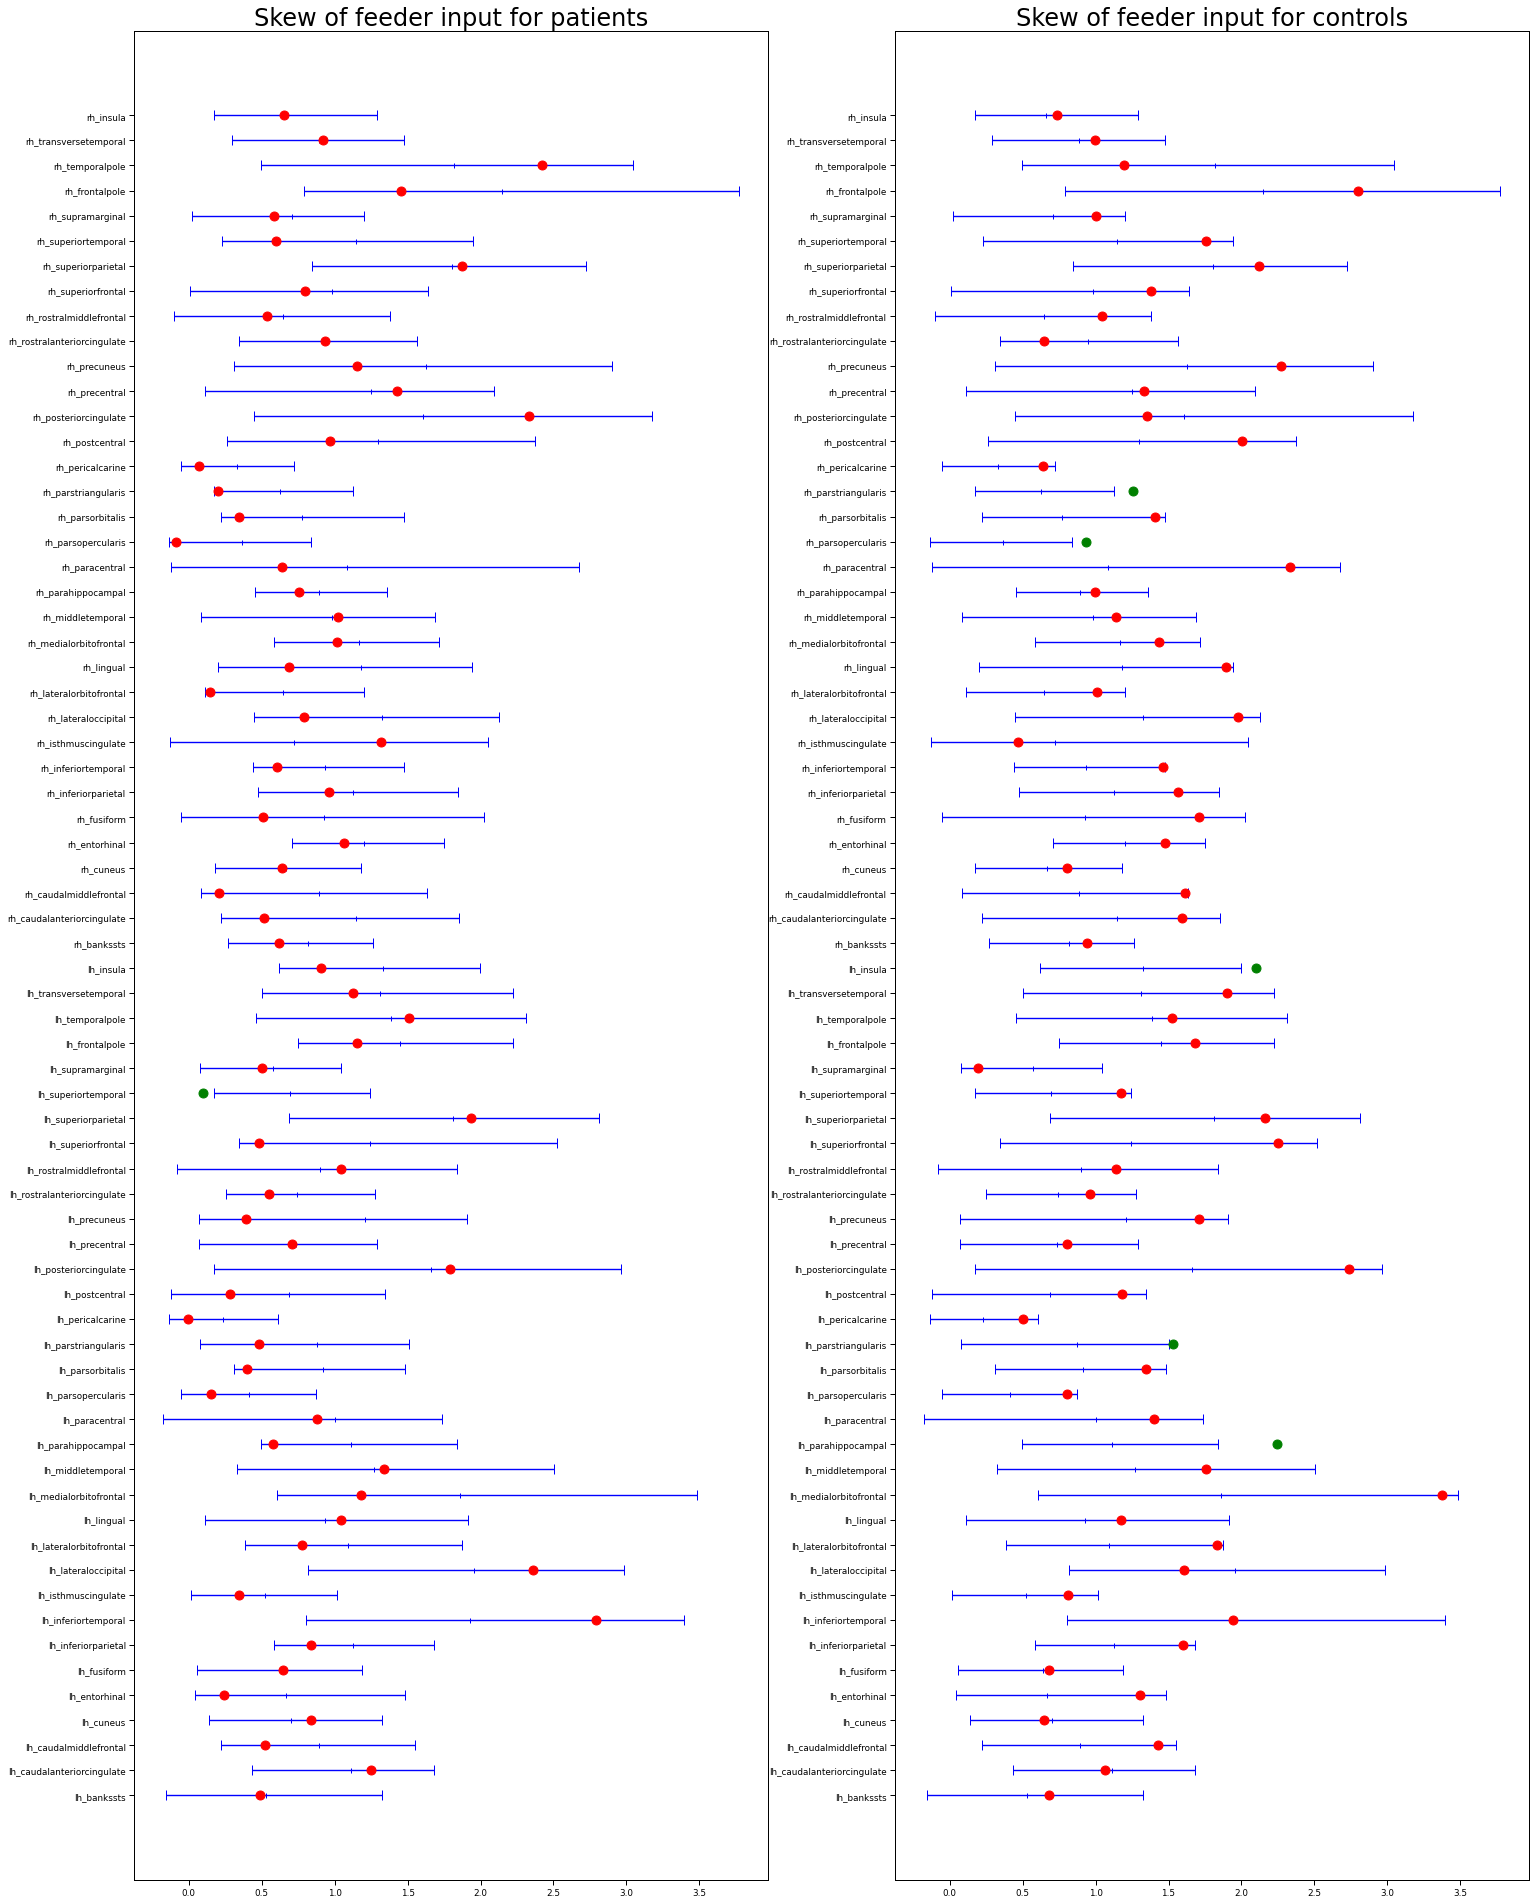

In [26]:
## Examine significance of skew of input(feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Skew of feeder input'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(input_patients,
                              input_controls,
                              stt.skew(input_patients[:n_subjects], axis=0),
                              stt.skew(input_controls[:n_subjects], axis=0),
                              statistic_description, y_labels, alpha, stt.skew)
else:
    examine_significance(input_patients, input_controls,
                              stt.skew(input_patients, axis=0),
                              stt.skew(input_controls, axis=0),
                              statistic_description, y_labels, alpha, stt.skew)

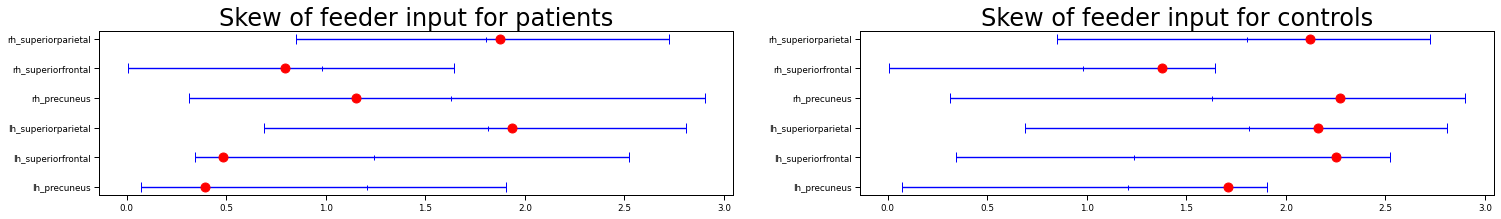

In [27]:
## Examine significance of skew of input(feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Skew of feeder input'
y_labels = roi_labels[indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(input_rc_patients,
                              input_rc_controls,
                              stt.skew(input_rc_patients[:n_subjects], axis=0),
                              stt.skew(input_rc_controls[:n_subjects], axis=0),
                              statistic_description, y_labels, alpha, stt.skew)
else:
    examine_significance(input_rc_patients, input_rc_controls,
                              stt.skew(input_rc_patients, axis=0),
                              stt.skew(input_rc_controls, axis=0),
                              statistic_description, y_labels, alpha, stt.skew)

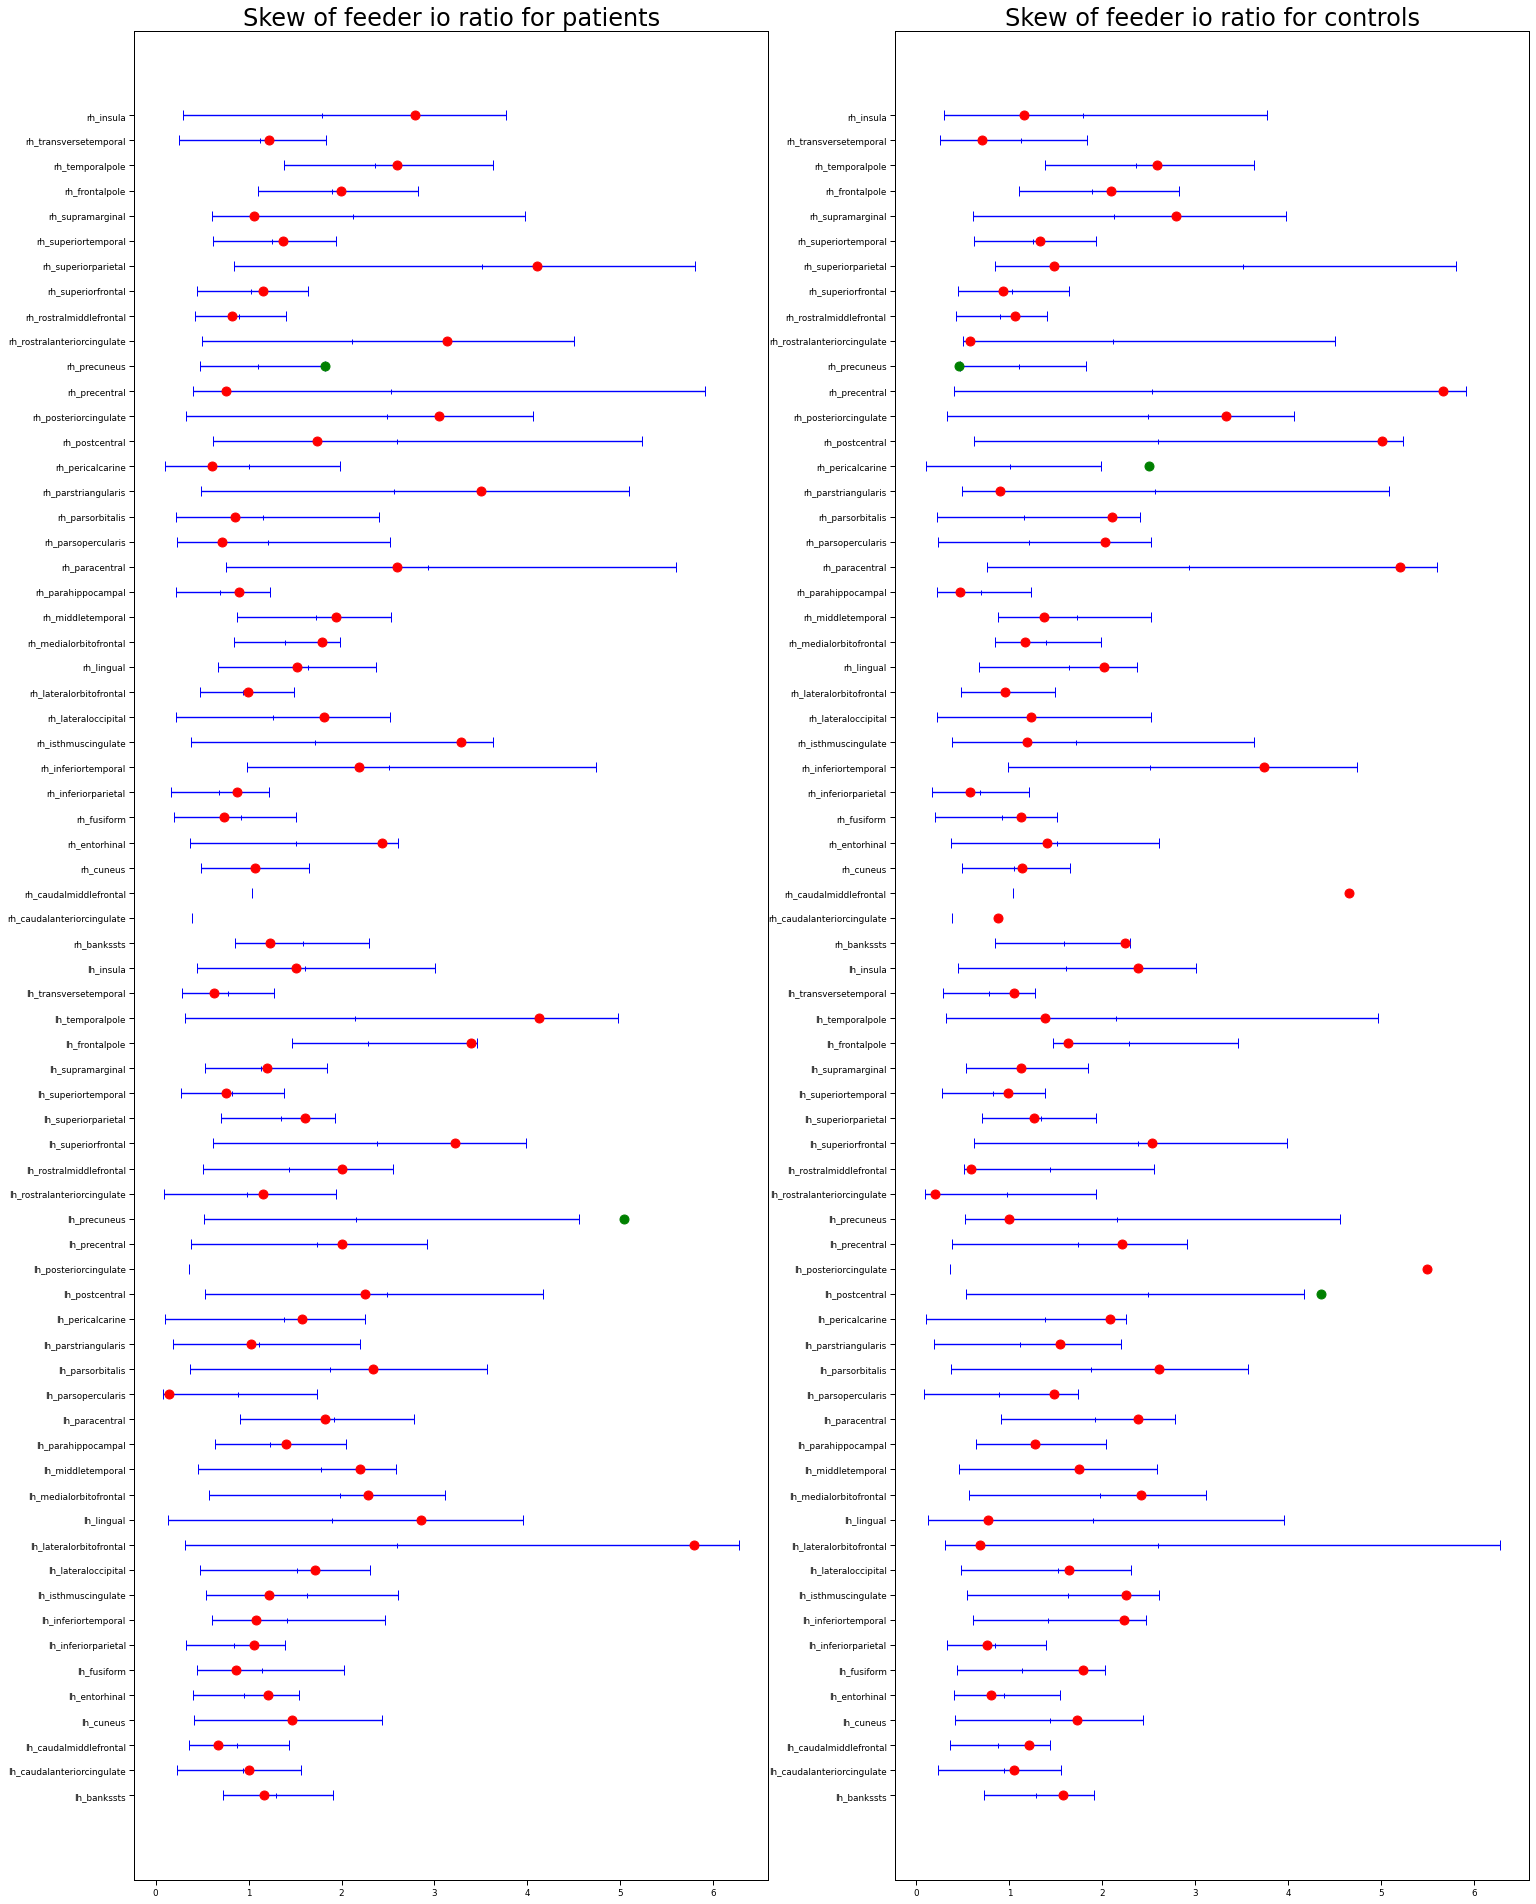

In [28]:
## Examine significance of skew of input(feeder)
alpha = 0.95
sample_groupsize = 'matched'
#sample_groupsize = 'all subjects'
statistic_description = 'Skew of feeder io ratio'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(io_ratio_patients,
                              io_ratio_controls,
                              stt.skew(io_ratio_patients[:n_subjects], axis=0),
                              stt.skew(io_ratio_controls[:n_subjects], axis=0),
                              statistic_description, y_labels, alpha, stt.skew)
else:
    examine_significance(io_ratio_patients, io_ratio_controls,
                              stt.skew(io_ratio_patients, axis=0),
                              stt.skew(io_ratio_controls, axis=0),
                              statistic_description, y_labels, alpha, stt.skew)

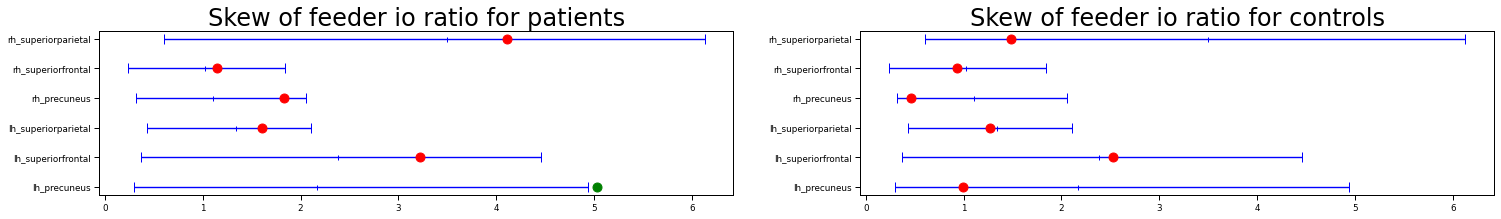

In [29]:
## Examine significance of skew of input(feeder)
alpha = 0.99
sample_groupsize = 'matched'
#sample_groupsize = 'all subjects'
statistic_description = 'Skew of feeder io ratio'
y_labels = roi_labels[indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(io_ratio_rc_patients,
                              io_ratio_rc_controls,
                              stt.skew(io_ratio_rc_patients[:n_subjects], axis=0),
                              stt.skew(io_ratio_rc_controls[:n_subjects], axis=0),
                              statistic_description, y_labels, alpha, stt.skew)
else:
    examine_significance(io_ratio_rc_patients, io_ratio_rc_controls,
                              stt.skew(io_ratio_rc_patients, axis=0),
                              stt.skew(io_ratio_rc_controls, axis=0),
                              statistic_description, y_labels, alpha, stt.skew)

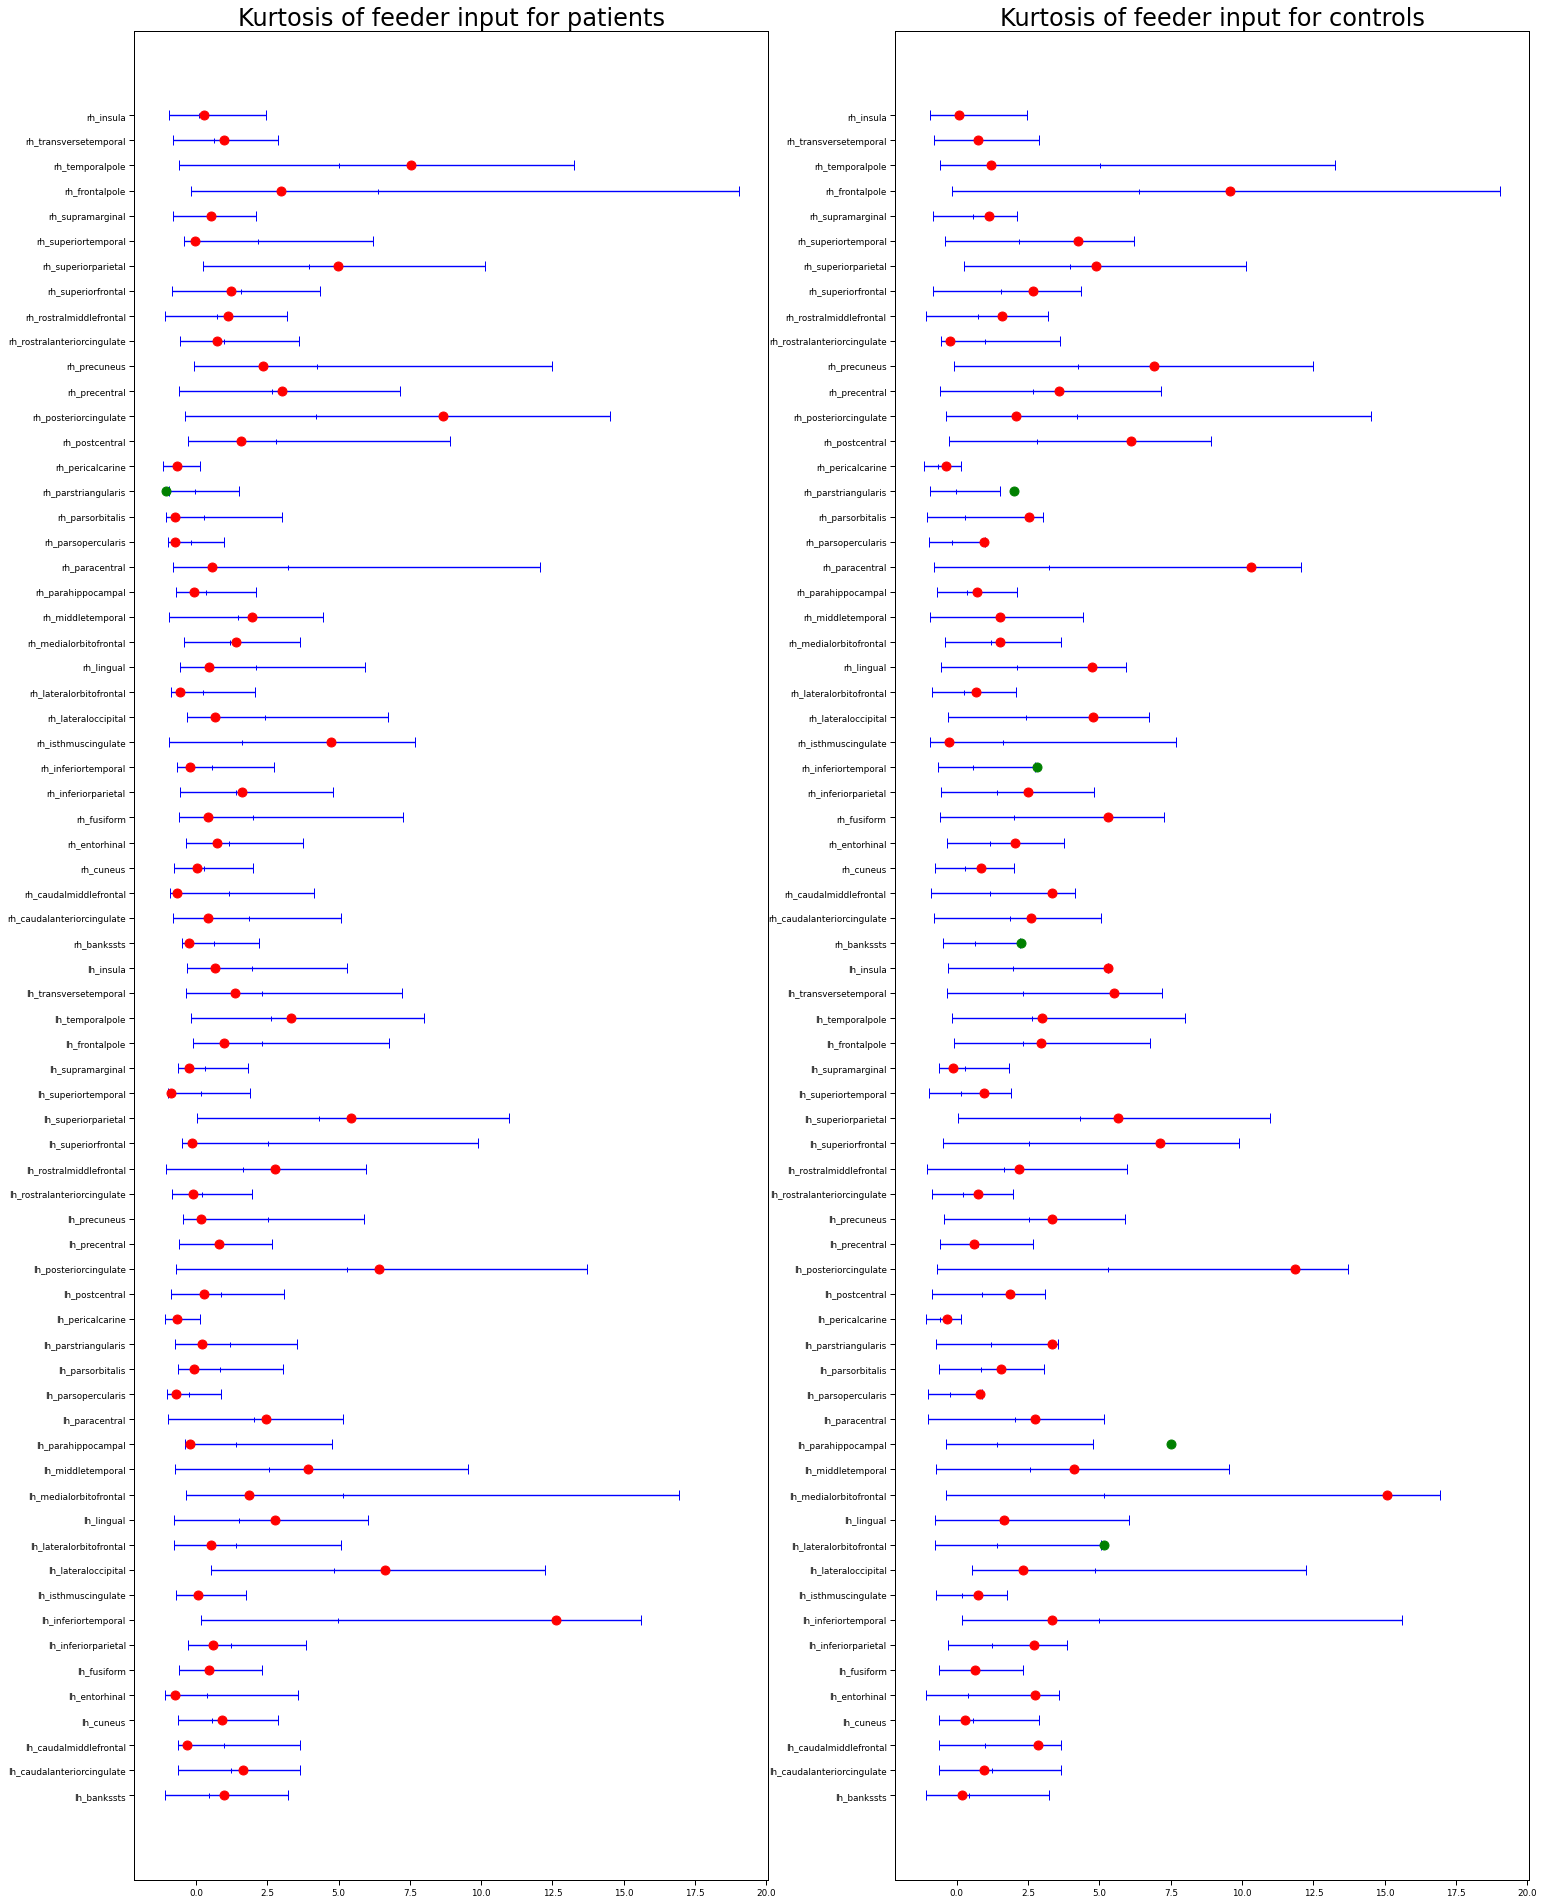

In [30]:
## Examine significance of kurtosis of input(feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Kurtosis of feeder input'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(input_patients,
                              input_controls,
                              stt.kurtosis(input_patients[:n_subjects], axis=0),
                              stt.kurtosis(input_controls[:n_subjects], axis=0),
                              statistic_description, y_labels, alpha, stt.kurtosis)
else:
    examine_significance(input_patients, input_controls,
                              stt.kurtosis(input_patients, axis=0),
                              stt.kurtosis(input_controls, axis=0),
                              statistic_description, y_labels, alpha, stt.kurtosis)

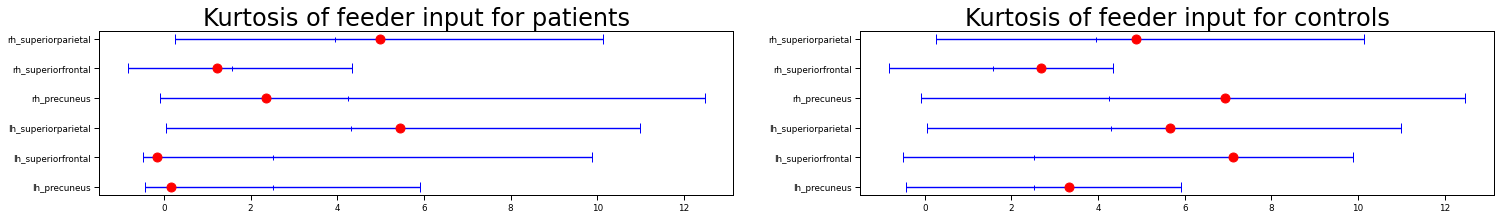

In [31]:
## Examine significance of kurtosis of input(feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Kurtosis of feeder input'
y_labels = roi_labels[indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(input_rc_patients,
                              input_rc_controls,
                              stt.kurtosis(input_rc_patients[:n_subjects], axis=0),
                              stt.kurtosis(input_rc_controls[:n_subjects], axis=0),
                              statistic_description, y_labels, alpha, stt.kurtosis)
else:
    examine_significance(input_rc_patients, input_rc_controls,
                              stt.kurtosis(input_rc_patients, axis=0),
                              stt.kurtosis(input_rc_controls, axis=0),
                              statistic_description, y_labels, alpha, stt.kurtosis)

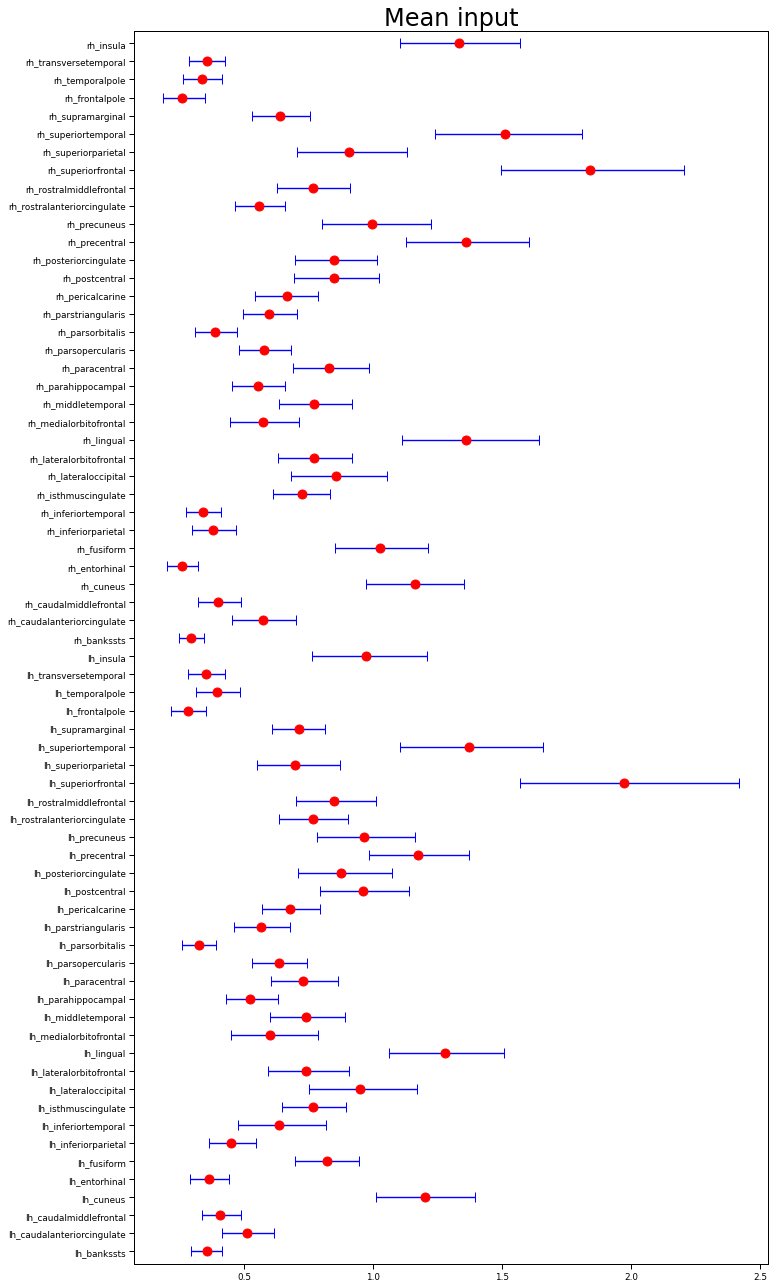

In [45]:
## Bootstrapping to determine whether the 1st 60 subjects of the control group are represenatative of that group.
statistic = input_controls.mean(axis=0)
n_samples = 10000
alpha = alpha # alpha percentile
lower_limit = int(np.floor(n_samples * (1 - alpha) / 2))
upper_limit = int(np.floor(n_samples * (1 + alpha) / 2))
sample_length = np.fmin(n_patients, n_controls)
rankordered_samples = np.zeros([n_samples, n_rois])
subj_indexes = np.arange(n_controls)
# Sampling.
np.random.seed(seed)
for i_sample in range(n_samples):
    index_sample = np.random.choice(
        subj_indexes, size=sample_length)
    rankordered_samples[i_sample, :] = input_controls[index_sample, :].mean(axis=0)

rankordered_samples = np.sort(rankordered_samples, axis=0)
rankordered_samples = rankordered_samples[lower_limit:upper_limit, :]
xerr = rankordered_samples[[0,-1], :]
xerr.shape

fontsize = 15
markersize = 18
y = np.arange(xerr.shape[1])
fig = plt.figure(figsize=(25, len(y_labels)/3))
plt.subplot(121)
plt.hlines(np.matlib.repmat(y, 2, 1), xmin=xerr[0], xmax=xerr[1], color='b')
plt.plot(xerr, np.matlib.repmat(y, 2, 1), '|', color='b', markersize=10)
plt.plot(rankordered_samples.mean(axis=0), y, '|', color='b', markersize=5)
for i_rc_roi in range(xerr.shape[1]):
    i_statistic = statistic[i_rc_roi]
    format_string = '.r'
    if (i_statistic > xerr.T[i_rc_roi,1] or
        i_statistic < xerr.T[i_rc_roi,0]):
        format_string = '.g' 
    plt.plot(i_statistic, y_labels[i_rc_roi],
             format_string, markersize=markersize)
plt.title('Mean input', fontsize=title_fontsize)
plt.show()